# Optimization of Production Cost: Steel Temperature Prediction Model

# Content <a id='back'></a>

* [Introduction](#intro)
    * [Project Description](#description)
    * [Data Description](#data_desc)
        * [Initialization](#init)
        * [Data Preparation](#data_prep)
            * [Data Loading](#data_load)
            * [Arc DataFrame](#arc)
            * [Bulk DataFrame](#bulk)
            * [Bulk Time DataFrame](#bulk_timt)
            * [Gas DataFrame](#gas)
            * [Temperature DataFrame](#temp)
            * [Wire DataFrame](#wire)
            * [Wire Time DataFrame](#wire_time)
            * [Summary](#summary_prep)
        * [Exploratory Data Analysis](#eda)
            * [Electrodes (Arc)](#arc2)
            * [Bulk Alloy](#bulk2)
            * [Inert Gas](#gas2)
            * [Temperature](#temp2)
            * [Wire Alloy](#wire2)
            * [Summary](#summary_eda)
        * [Data Preprocessing](#data_prepro)
            * [Electrodes (Arc)](#arc3)
            * [Temperature](#temp3)
            * [Merging Table](#merge)
            * [Summary](#summary_prepro)
* [Methodology](#method)
* [Train-Test Split](#split)
* [Modeling](#Modeling)
    * [Linear Regression](#lr)
    * [Ridge](#ridge)
    * [Catboost](#catboost)
    * [XGBoost](#xgboost)
    * [LightGBM](#lightgbm)
* [Model Evaluation](#evaluation)
    * [Model Comparation](#compare)
    * [Test Best Model](#test)
* [Discussion](#discuss)
    * [Analysis](#analysis)
    * [Model Evaluation Report](#report)
    * [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

### Project Description <a id='description'></a>

In this project, we aim to optimize production costs at the steel plant "Steelproof" by developing a predictive model for the temperature of the metal during the steel processing stages. The steel processing involves various steps, including ladle heating, desulfurization, chemical composition correction, alloying, and temperature measurement.

**Task**

Build a model to predict the temperature of final steel product.

**Steel processing steps:**

1. Molten steel is poured into a ladle and heated using graphite electrodes.
2. Desulfurization process by adding alloy to corrected chemical composition in the form of bulk material or wire.
3. Measurement of temperature and analysis of chemical composition by taking samples.
4. By adding alloying materials, alloy is purged with inert gas and stirred. 
5. The cycle repetition until desired composition and temperature are achieved.
6. Refined or transferred into a continuous casting machine for solidification.

### Data Description <a id='data_desc'></a>

The data for this project is sourced from different files in '\datasets\final_steel\' folder (if its on server), each providing information on specific aspects of the steel processing. The key files include:

- `data_arc.csv`: Electrode data.
- `data_bulk.csv`: Bulk material supply data (volume).
- `data_bulk_time.csv`: Bulk material delivery data (time).
- `data_gas.csv`: Gas purge data.
- `data_temp.csv`: Temperature measurement results.
- `data_wire.csv`: Wire materials data (volume).
- `data_wire_time.csv`: Wire materials data (time).

Each file contains a `key` column representing the batch number, and there may be several rows with the same key value corresponding to different processing iterations.

#### Initialization <a id='init'></a>

In [2]:
# Dataframe lib
import pandas as pd
import numpy as np

# Visualization lib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Catboost Regressor
from catboost import CatBoostRegressor
from catboost import Pool

# LightGBM Regressor
from lightgbm import LGBMRegressor

# XGBoost Regressor
from xgboost import XGBRegressor

# Hyperparameter Tuning
import optuna

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data Preparation <a id='data_prep'></a>

##### Data Loading <a id='data_load'></a>

In [3]:
# Load data into dataframes
try:
    arc_df = pd.read_csv('final_steel_en\data_arc_en.csv')
    bulk_df = pd.read_csv('final_steel_en\data_bulk_en.csv')
    bulk_time_df = pd.read_csv('final_steel_en\data_bulk_time_en.csv')
    gas_df = pd.read_csv('final_steel_en\data_gas_en.csv')
    temp_df = pd.read_csv('final_steel_en\data_temp_en.csv')
    wire_df = pd.read_csv('final_steel_en\data_wire_en.csv')
    wire_time_df = pd.read_csv('final_steel_en\data_wire_time_en.csv')
except:
    arc_df = pd.read_csv('/datasets/final_steel_en\data_arc_en.csv')
    bulk_df = pd.read_csv('/datasets/final_steel_en\data_bulk_en.csv')
    bulk_time_df = pd.read_csv('/datasets/final_steel_en\data_bulk_time_en.csv')
    gas_df = pd.read_csv('/datasets/final_steel_en\data_gas_en.csv')
    temp_df = pd.read_csv('/datasets/final_steel_en\data_temp_en.csv')
    wire_df = pd.read_csv('/datasets/final_steel_en\data_wire_en.csv')
    wire_time_df = pd.read_csv('/datasets/final_steel_en\data_wire_time_en.csv')

##### Arc DataFrame <a id='arc'></a>

In [4]:
# Show data sample
arc_df.head()

,key,Arc heating start,Arc heating end,Active power,Reactive power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
# Rename Columns
arc_df.columns = ['key', 'start_arc', 'end_arc', 'active_power', 'reactive_power']

In [6]:
# Show general information
arc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_arc       14876 non-null  object 
 2   end_arc         14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [7]:
# Check data duplicate
arc_df.duplicated().sum()

0

In [8]:
# Convert data type
arc_df['start_arc'] = pd.to_datetime(arc_df['start_arc'])
arc_df['end_arc'] = pd.to_datetime(arc_df['end_arc'])

The `arc_df` dataframe contains data about the electrodes. No gaps and duplicate values found. Instead there is time-related column that need to convert. Need more explanation about active and reactive power so the total power can calculate.

##### Bulk DataFrame <a id='bulk'></a>

In [9]:
# Show data sample
bulk_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [10]:
# Rename columns
bulk_df.rename(
    columns={
        col: col.lower().replace(' ','_') for col in bulk_df.columns if col != 'key'
    }, inplace=True
)

In [11]:
# Show general information
bulk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


In [12]:
# Check duplicates
bulk_df.duplicated().sum()

0

The `bulk_df` dataframe stores data about volume of the bulk materials alloyed. There are 15 bulk materials conducted. The bulk material added when melting metal substances are not achieves certain composition. There are no duplicated values. Beside that there are many gaps in the data since that only missing substances added for certain batch.

##### Bulk Time DataFrame <a id='bulk_time'></a>

In [13]:
# Show data sample
bulk_time_df.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [14]:
# Rename columns
bulk_time_df.rename(
    columns={
        col: col.lower().replace(' ','_') for col in bulk_time_df.columns if col !='key'
    }, inplace=True
)

In [15]:
# Show general information
bulk_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


In [16]:
# Check duplicates
bulk_time_df.duplicated().sum()

0

The `bulk_time_df` dataframe contains time data about supply of bulk materials related to `bulk_df` dataframe. The gaps is identical with the gaps in the `bulk_df` dataframe due to the same reasons.

##### Gas DataFrame <a id='gas'></a>

In [17]:
# Show data sample
gas_df.head()

,key,Gas 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [18]:
# Rename columns
gas_df.columns = ['key', 'gas']

In [19]:
# Show general information
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [20]:
# Check data duplicate
gas_df.duplicated().sum()

0

The `gas_df` dataframe stores data about gas volume on when alloy purged. No gaps and duplicates found.

##### Temperature DataFrame <a id='temp'></a>

In [21]:
# Show data sample
temp_df.head()

,key,Sampling time,Temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [22]:
# Rename columns
temp_df.columns = ['key','time_sampling', 'temp']

In [23]:
# Show geenral information
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            15907 non-null  int64  
 1   time_sampling  15907 non-null  object 
 2   temp           13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [24]:
# Check data duplicates
temp_df.duplicated().sum()

0

In [25]:
# Convert data type
temp_df['time_sampling'] = pd.to_datetime(temp_df['time_sampling'])

The `temp_df` dataframe provides information on the temperature of the steel at various stages of production. However, it is observed that there are gaps in the `temp` column. These gaps may have occurred due to errors or inaccuracies during the input process when samples were taken.

##### Wire DataFrame <a id='wire'></a>

In [26]:
# Show data sample
wire_df.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Rename columns
wire_df.rename(
    columns={
        col: col.lower().replace(' ', '_') for col in wire_df.columns if col != 'key'
    },inplace=True
)

In [28]:
# Show general information
wire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [29]:
# Check data duplicates
wire_df.duplicated().sum()

0

The `wire_df` table contains information about the volume of wire materials used in the steel production process. In total, there are 9 types of wire materials. Similar to bulk materials, wire materials also added to achieving specific steel grades based on the composition of the starting materials. The gaps in this dataframe exist due to that reason.

##### Wire Time DataFrame <a id='wire_time'></a>

In [30]:
# Show data sample
wire_time_df.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Rename columns
wire_time_df.rename(
    columns={
        col: col.lower().replace(' ', '_') for col in wire_time_df.columns if col != 'key'
    },inplace=True
)

In [32]:
# Show general information
wire_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [33]:
# Check data duplicates
wire_time_df.duplicated().sum()

0

In [34]:
# Convert data type
for col in wire_time_df.columns:
    if col != 'key':
        wire_time_df[col] = pd.to_datetime(wire_time_df[col])

The `wire_time_df` dataframe contains information about the time of wire added to melted metal identical with `wire_df`.

##### Summary <a id='summary'></a>


We have total 7 dataframe containing information on electrodes, bulk materials (volume and supply time), gas purge, wire materials (volume and time), and steel temperature measurements on certain batch. The next step is to analyze and preprocess data in order to build predictive model.

#### Exploratory Data Analysis (EDA) <a id='eda'></a>

During EDA, we aim to analyze key aspects for each key column in the dataset:

1. Duration between the first and last temperature measurement.
2. Total electrode heating time (sum of intervals between launches).
3. Number of electrode heating launches.
4. Average correlation between active and reactive power consumption.

Also calculate statistics such as average, minimum, maximum, median, and percentiles (25% and 75%) for each column. These calculations provide insights into the temporal aspects of temperature measurements, electrode heating characteristics, and power consumption patterns. 

##### Electrode (Arc) <a id='arc2'></a>

In [35]:
# Describe dataframe
arc_df.describe()

,key,start_arc,end_arc,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-02 16:15:28.218203904,2019-07-02 16:18:19.889150208,0.670441,0.452592
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.030002,-715.504924
25%,806.000000,2019-06-02 07:01:09.249999872,2019-06-02 07:04:21,0.395297,0.290991
50%,1617.000000,2019-06-30 09:57:14.500000,2019-06-30 10:01:01,0.555517,0.415962
75%,2429.000000,2019-08-03 13:04:47.750000128,2019-08-03 13:09:14,0.857034,0.637371
max,3241.000000,2019-09-01 04:34:47,2019-09-01 04:36:08,3.731596,2.676388
std,934.571502,NaN,NaN,0.408159,5.878702


c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


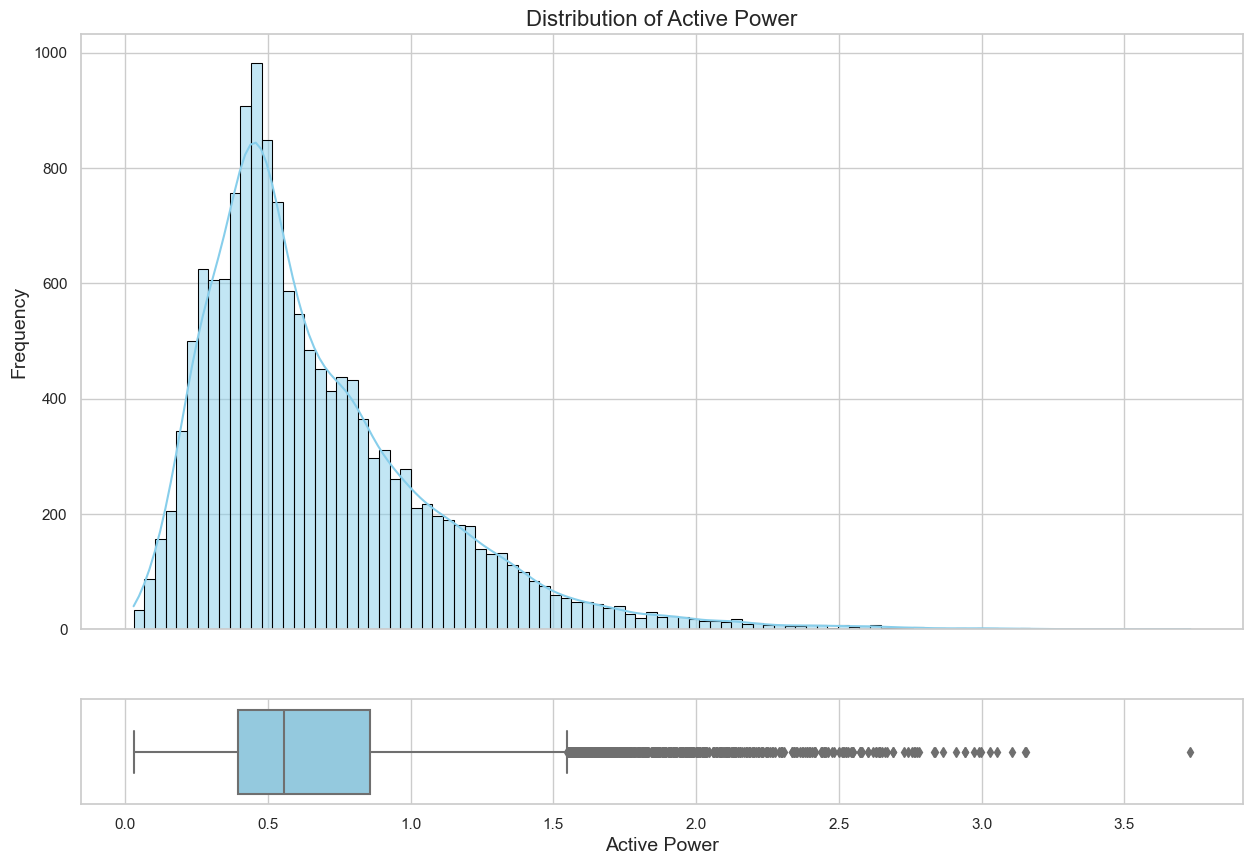

In [36]:
# Set style
sns.set(style="whitegrid")

# Create subplots
f, (ax_hist, ax_box) = plt.subplots(2, figsize=(15, 10), sharex=True, gridspec_kw={"height_ratios": (.85, .15)})

# Histogram with KDE
sns.histplot(data=arc_df, x="active_power", kde=True, ax=ax_hist, color='skyblue', edgecolor='black')
ax_hist.set_ylabel('Frequency', fontsize=14)
ax_hist.set_xlabel('Active Power', fontsize=14)
ax_hist.set_title('Distribution of Active Power', fontsize=16)

# Boxplot
sns.boxplot(x=arc_df['active_power'], ax=ax_box, color='skyblue')
ax_box.set_xlabel('Active Power', fontsize=14)

# Display the plot
plt.show()

In [37]:
# Calculate 95% of the 'active_power'
arc_df['active_power'].quantile(0.95)

1.4480887598499999

The `active_power` of the electrodes exhibits a considerable range, spanning from 0.67 to 3.73. However, the majority of the data, representing 95%, falls within the range up to 1.45. It's worth noting that active power can occasionally reach 3.73, particularly during processes involving a significant addition of materials. We may exclude such extreme values from our analysis.

In [38]:
# Calculate negative value of the 'reactive_power'
(arc_df['reactive_power'] < 0).sum()

1

The minimum `reactive_power` is -715.5, an exceptionally large negative value. While `reactive_power` can indeed be negative, such an extreme value suggests an anomaly, possibly an overshoot of measurement or melt processing considering the maximum value for `reactive_power` is only 2.68.

Considering the task of forecasting the final temperature of steel, it is crucial to remove not just the single line with a negative `reactive_power` value but the entire dataset associated with this batch of steel. This ensures the integrity of our data for a more accurate analysis and prediction.

In [39]:
# Find the number of the batch
arc_df[arc_df['reactive_power']<0]

,key,start_arc,end_arc,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [40]:
# Remove the data contain negative value on 'reactive_power'
arc_df = arc_df[arc_df['key'] != 2116]

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


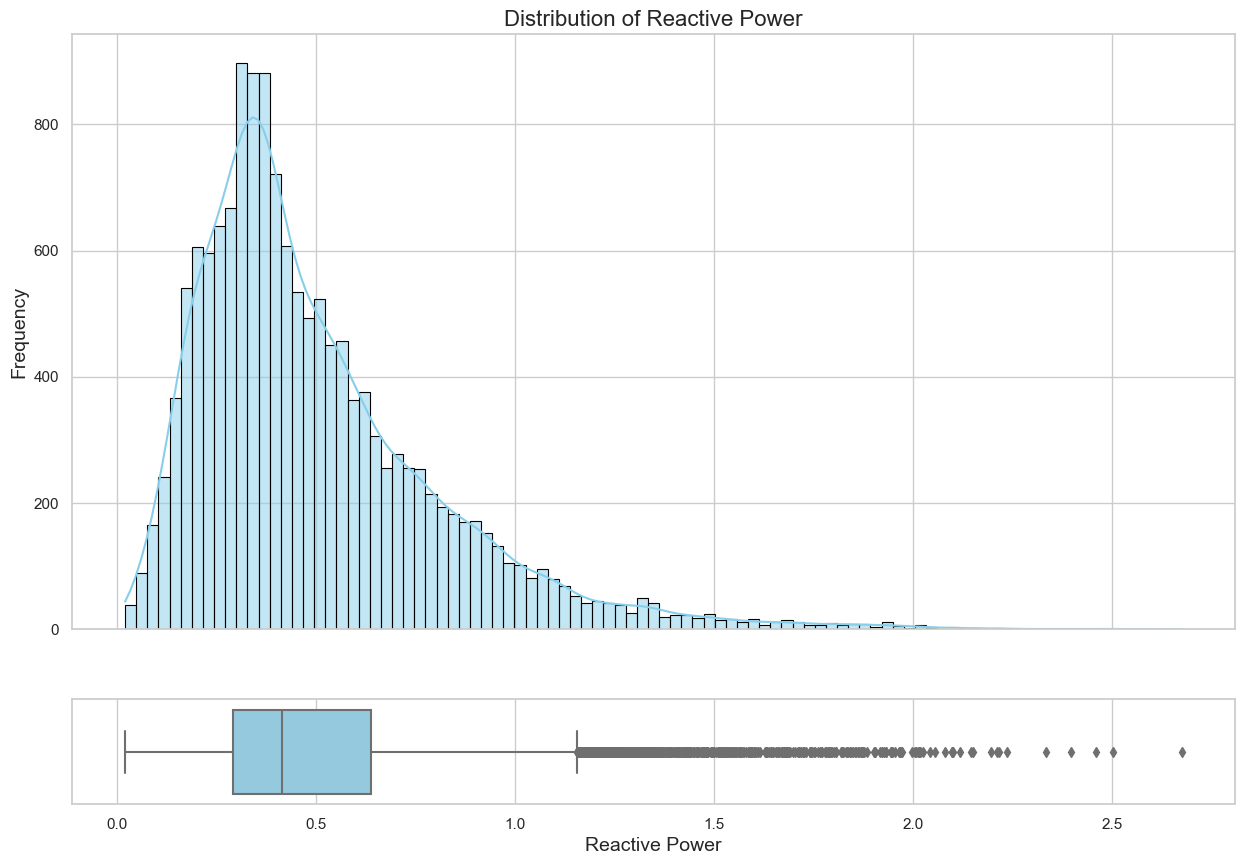

In [41]:
# Set style
sns.set(style="whitegrid")

# Create subplots
f, (ax_hist, ax_box) = plt.subplots(2, figsize=(15, 10), sharex=True, gridspec_kw={"height_ratios": (.85, .15)})

# Histogram with KDE
sns.histplot(data=arc_df, x="reactive_power", kde=True, ax=ax_hist, color='skyblue', edgecolor='black')
ax_hist.set_ylabel('Frequency', fontsize=14)
ax_hist.set_xlabel('Reactive Power', fontsize=14)
ax_hist.set_title('Distribution of Reactive Power', fontsize=16)

# Boxplot
sns.boxplot(x=arc_df['reactive_power'], ax=ax_box, color='skyblue')
ax_box.set_xlabel('Reactive Power', fontsize=14)

# Display the plot
plt.show()

There are also outlier in `reactive_power`.

##### Bulk Alloy <a id='bulk2'></a>

In [42]:
# Describe dataframe
bulk_df.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [43]:
def plot(data):
    for col in data.columns:
        if col != 'key' and col in data.select_dtypes(include=np.number).columns.tolist():
            # Create subplots
            fig, (ax_hist, ax_box) = plt.subplots(2, figsize=(12, 5), sharex=True, gridspec_kw={"height_ratios": (.85, .15)})
            
            # Plot histogram
            sns.histplot(data=data, x=col, kde=True, ax=ax_hist, color='skyblue', edgecolor='black')
            ax_hist.set_ylabel('Frequency', fontsize=12)
            ax_hist.set_xlabel(f'{col}', fontsize=12)
            ax_hist.set_title(f'Distribution of {col}', fontsize=14)
            
            # Plot boxplot
            sns.boxplot(x=data[col], ax=ax_box, color='skyblue')
            ax_box.set_xlabel(f'{col}', fontsize=12)

            # Adjust layout
            plt.tight_layout()

            # Show plot
            plt.show()

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


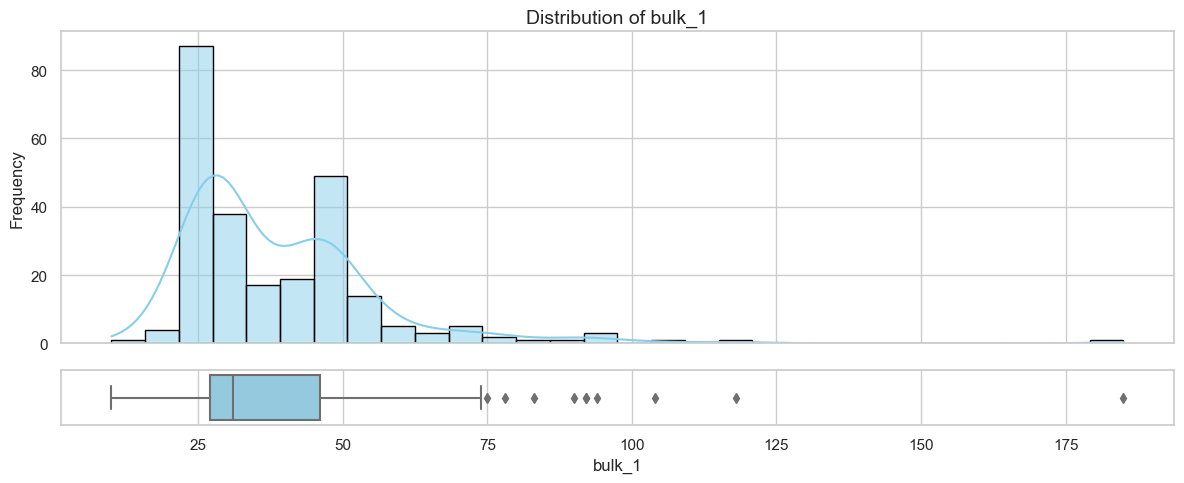

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


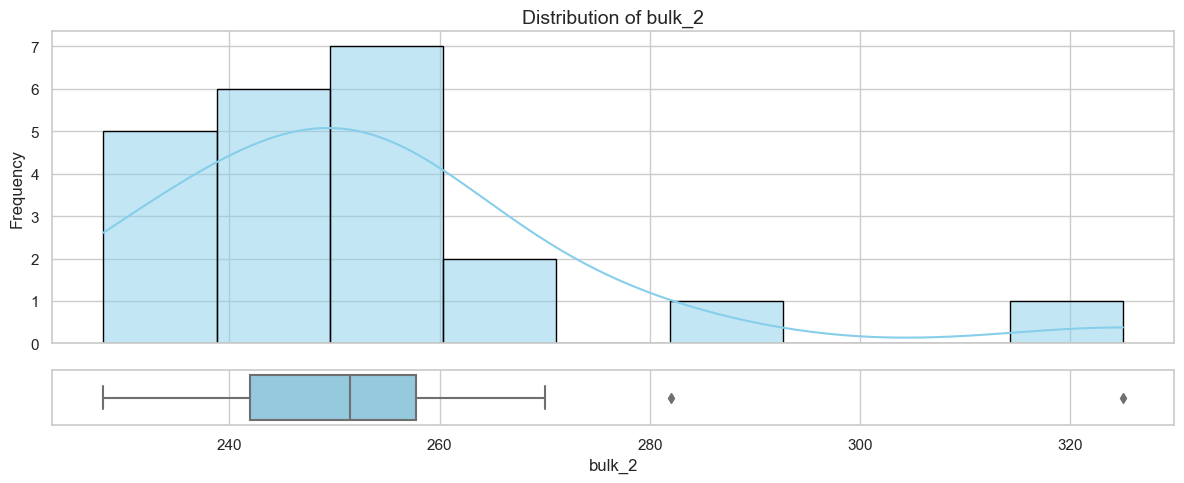

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


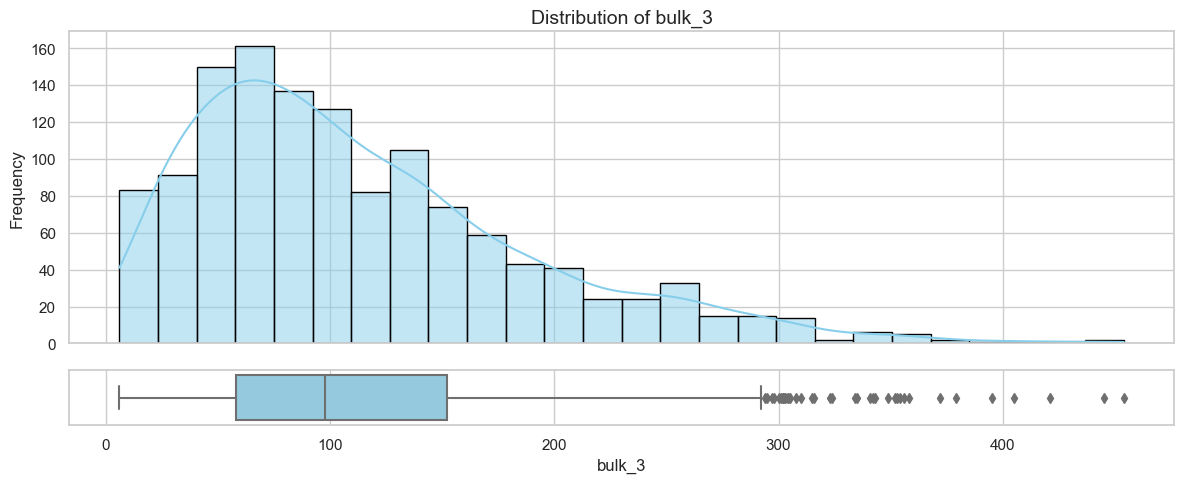

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


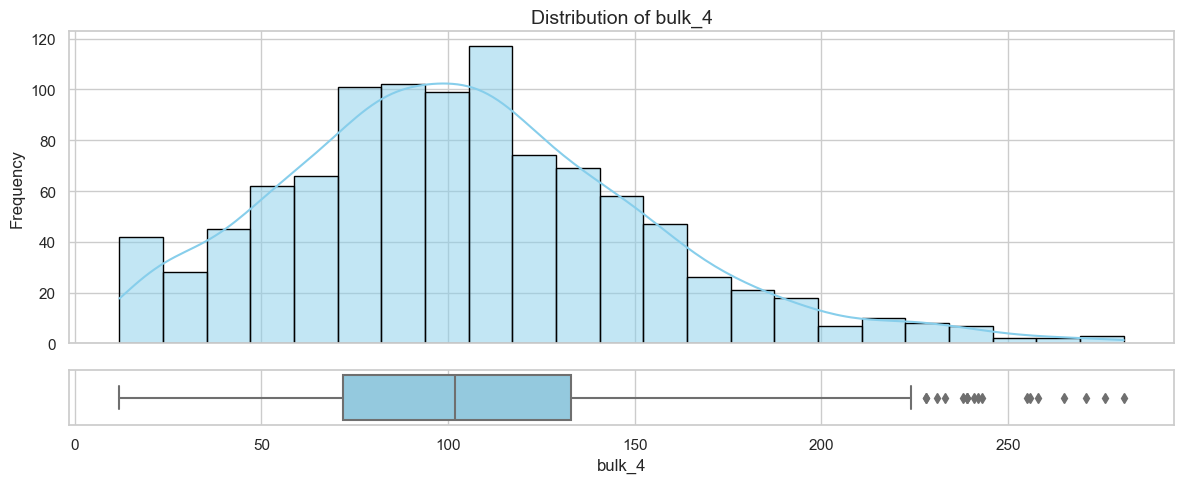

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


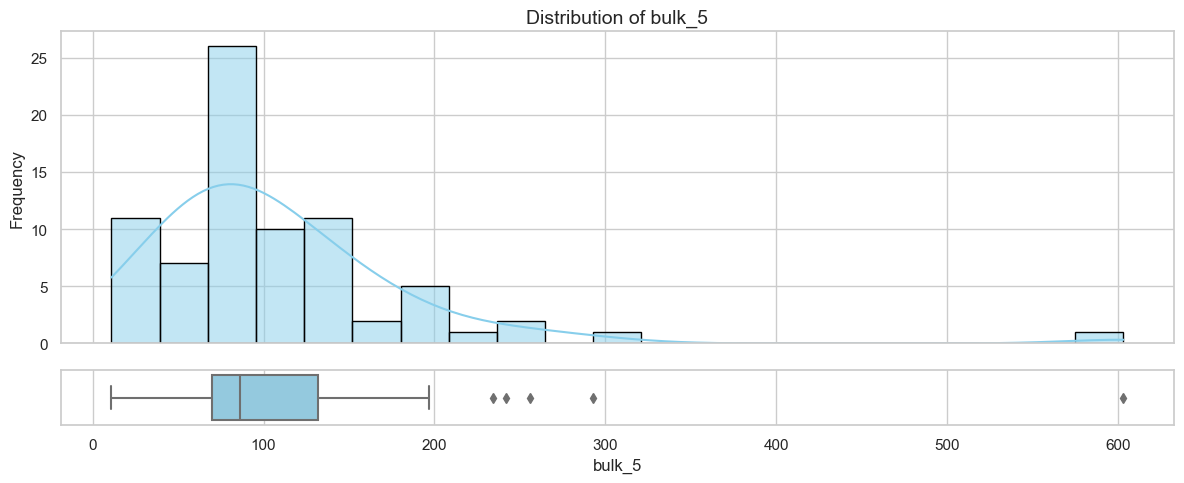

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


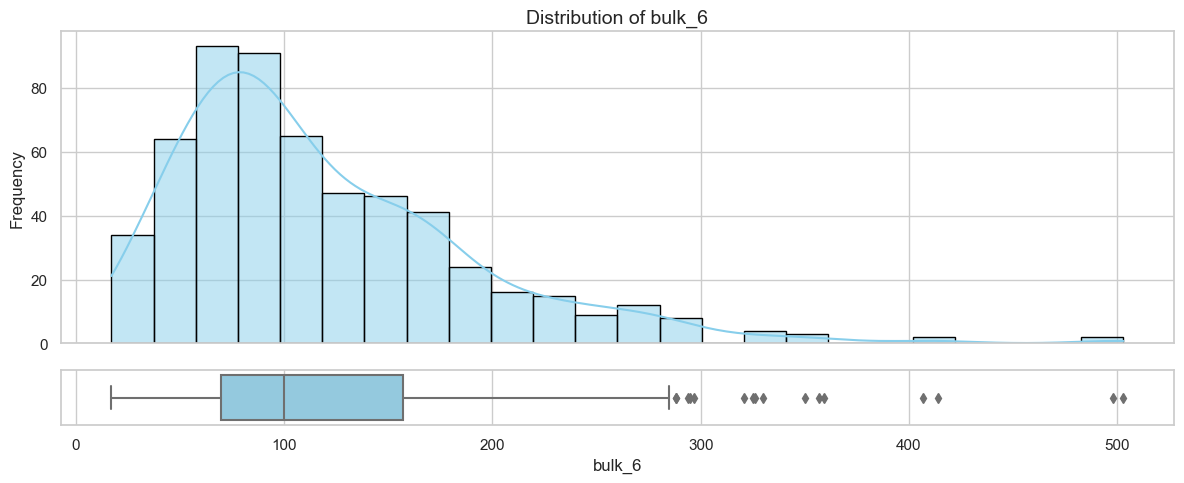

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


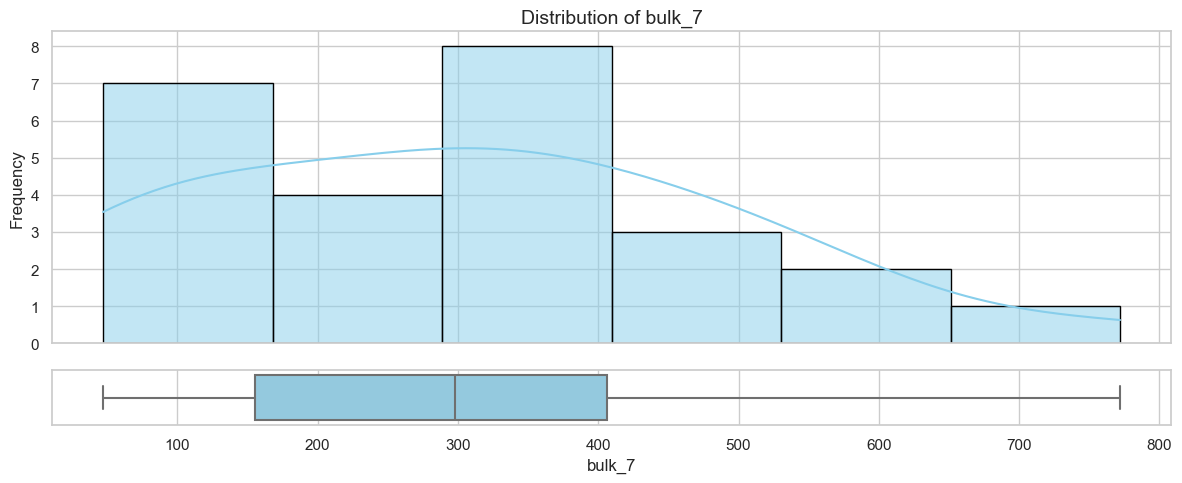

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


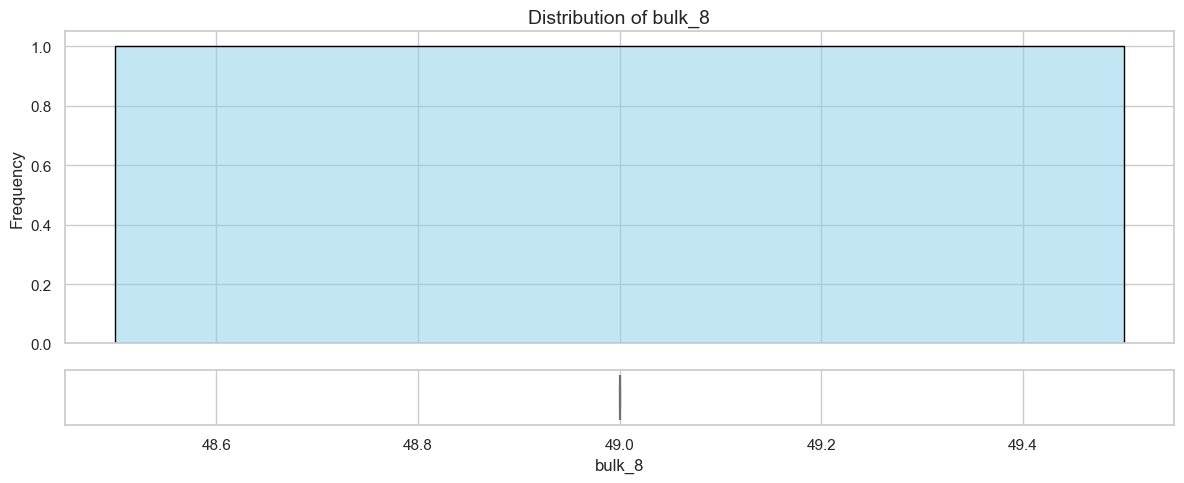

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


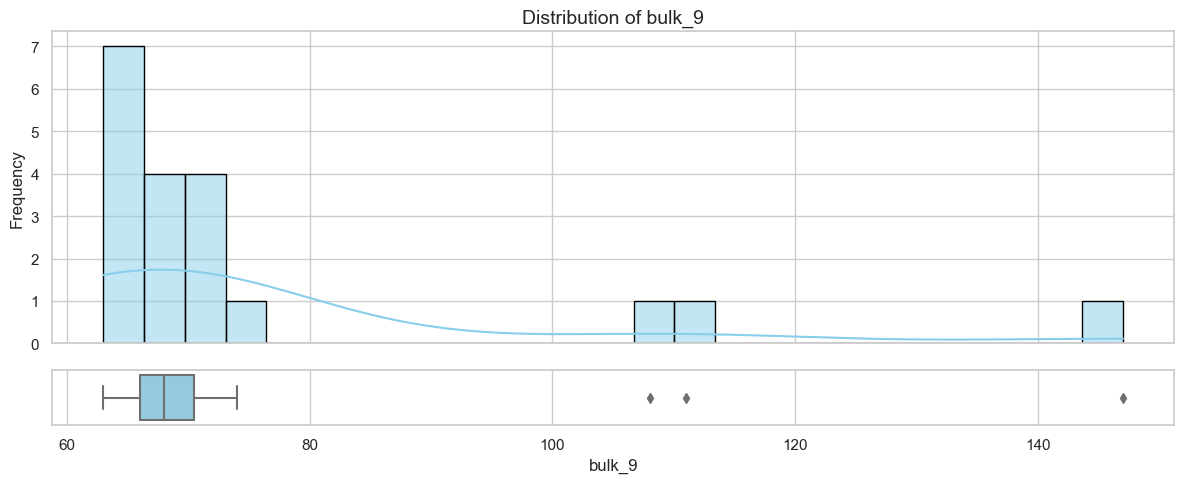

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


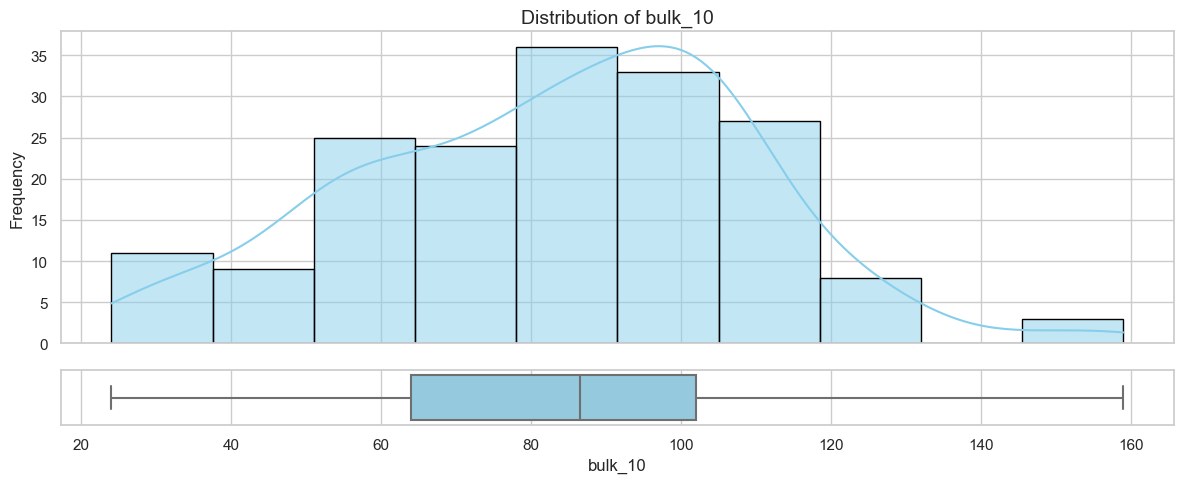

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


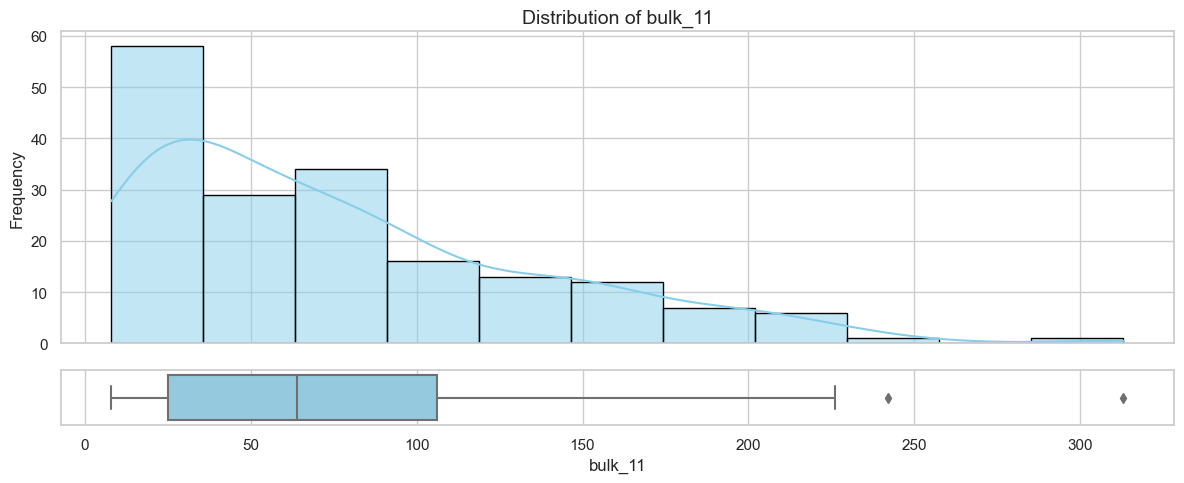

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


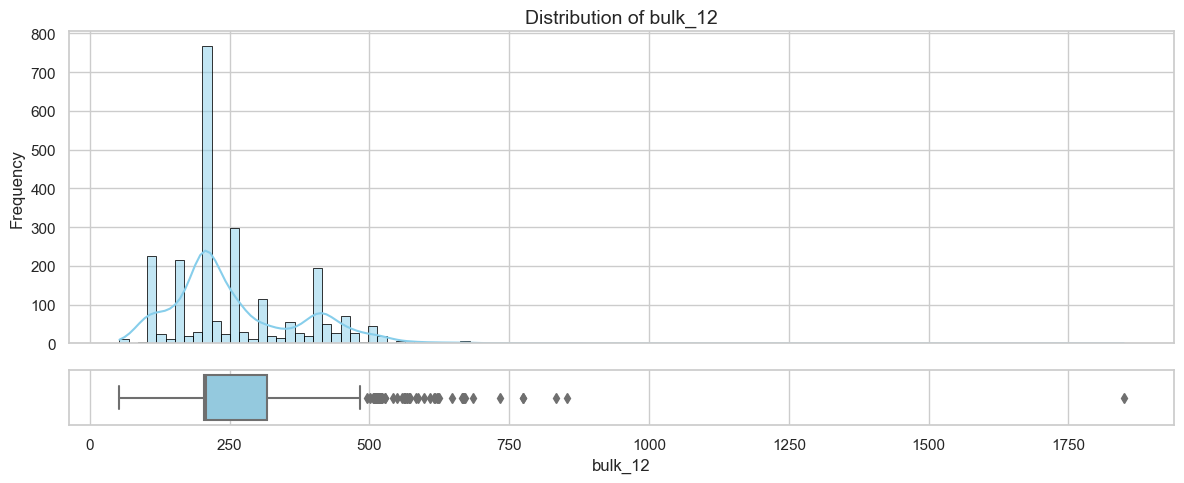

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


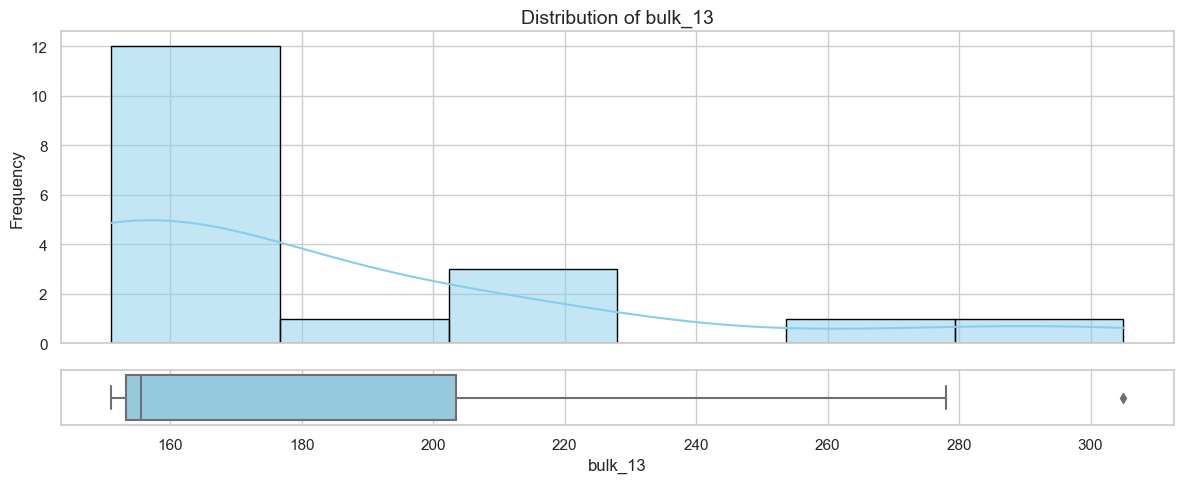

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


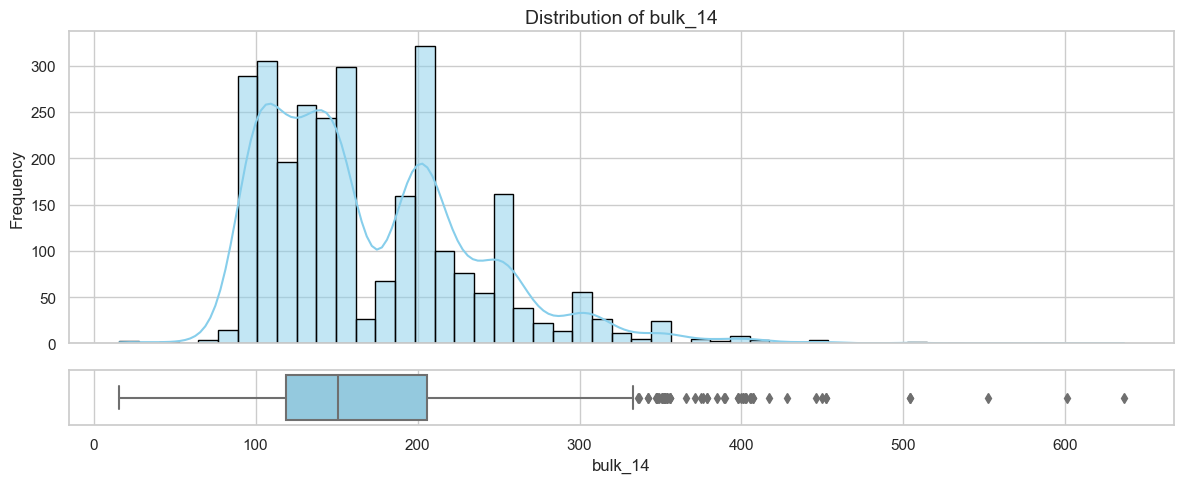

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


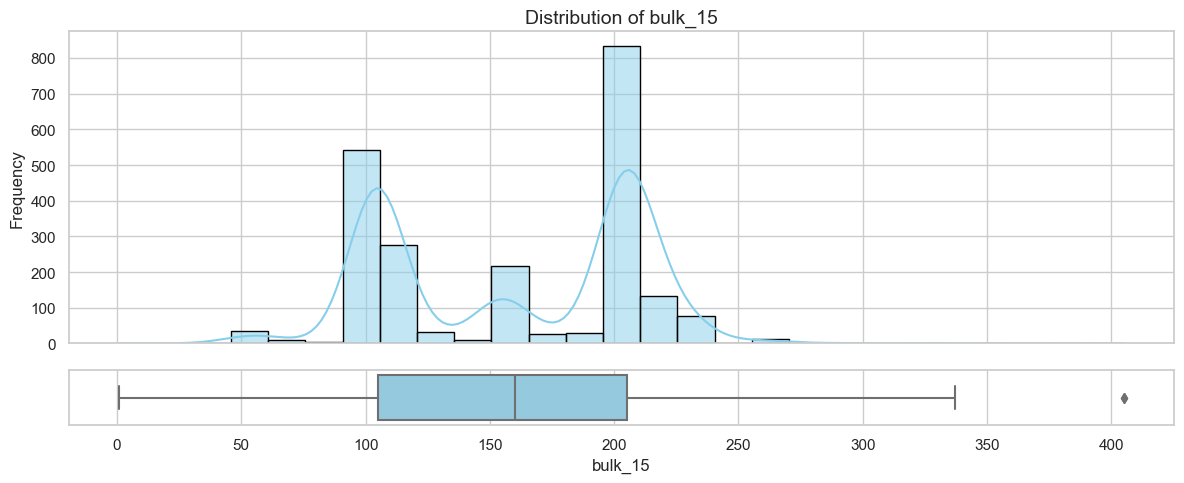

In [44]:
plot(bulk_df)

- **bulk_1** spans from 10 to 185, with 75% of values falling below 46, recorded 252 times.
- **bulk_2** spans from 228 to 352, and 75% of the values are under 257, recorded 22 times.
- **bulk_3** spans from 6 to 454, with 75% below 152, and recorded 1298 times.
- **bulk_4** spans from 12 to 281, with 75% under 133, recorded 1014 times.
- **bulk_5** spans from 11 and 603, with 75% below 132, and recorded 77 times.
- **bulk_6** spans from 17 to 503, and 75% are under 157, recorded 576 times.
- **bulk_7** spans from 47 to 772, with 75% below 406, and recorded 25 times.
- **bulk_8** appears once with a value of 49.
- **bulk_9** spans from 63 to 147, with 75% below 70.5, recorded 19 times.
- **bulk_10** spans from 24 to 159, with 75% below 70.5, and recorded 176 times.
- **bulk_11** spans from 8 to 313, with 75% below 106, and recorded 177 times.
- **bulk_12** spans from 53 to 1849, with 75% below 316, recorded 2450 times.
- **bulk_13** spans from 151 to 305, with 75% below 203, and recorded 18 times.
- **bulk_14** spans from 16 to 636, with 75% below 205.75, and recorded 2806 times.
- **bulk_15** spans from 1 to 405, with 75% below 205, and recorded 2248 times.

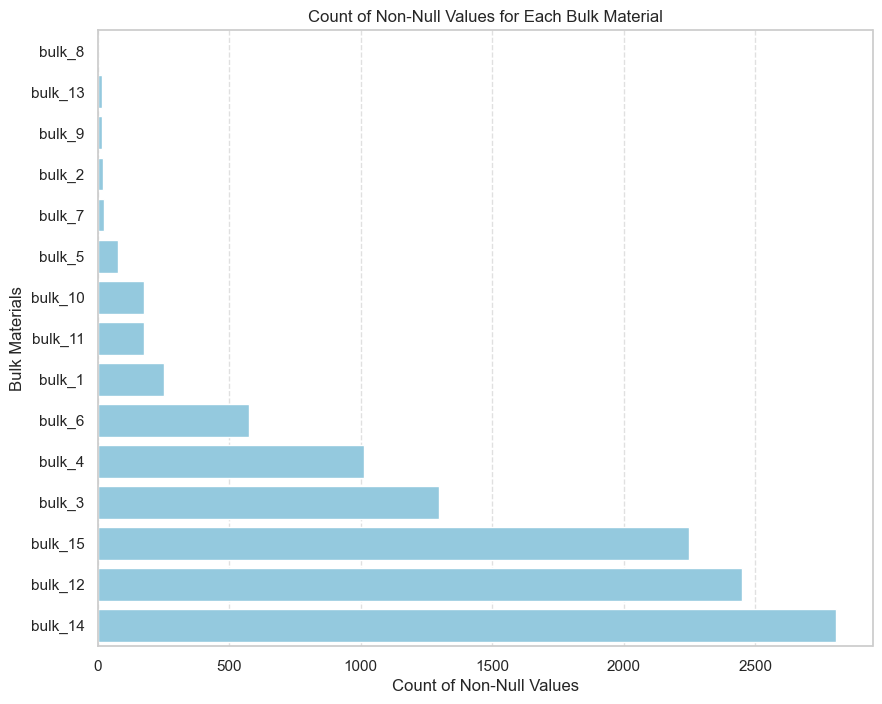

In [45]:
# Count non-null values for each column
non_null_counts = bulk_df.loc[:, 'bulk_1':].notna().sum().sort_values()

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=non_null_counts, y=non_null_counts.index, color='skyblue')
plt.title('Count of Non-Null Values for Each Bulk Material')
plt.xlabel('Count of Non-Null Values')
plt.ylabel('Bulk Materials')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the plot
plt.show()

Bulk materials like `bulk_2`, `bulk_8`, `bulk_9`, and `bulk_13` are rarely alloyed, while others such as `bulk_12`, `bulk_14`, and `bulk_15` are alloyed more frequently, reflecting variations in the steel-making process. The volume of use for most bulk materials varies significantly, influenced by the initial composition and grade targeted.

##### Inert Gas <a id='gas2'></a>

In [46]:
# Describe dataframe
gas_df.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


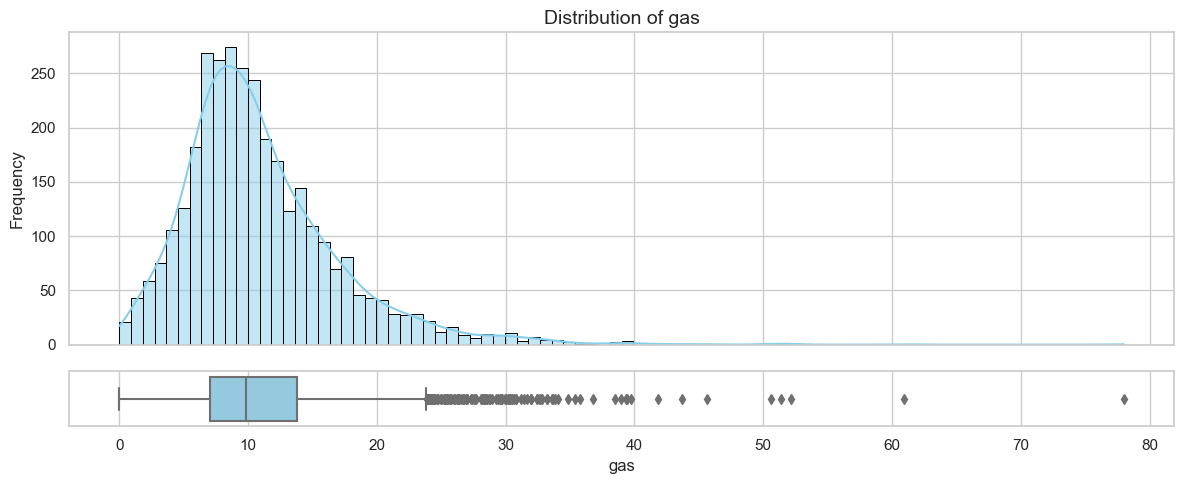

In [47]:
plot(gas_df)

The `gas` volume used ranges from 0.008 to 77.99. The majority of `gas` data falls within values up to 24. The variation in gas volume is expected, as it is influenced by the mixing of the workpiece. Small additions of bulk and wire materials result in less gas usage, while larger additions lead to increased `gas` consumption. Thus, the broad spread in `gas` volume values is not considered an anomaly.

##### Temperature <a id='temp2'></a>

In [48]:
# Describe dataframe
temp_df.describe()

,key,time_sampling,temp
count,15907.000000,15907,13006.000000
mean,1607.880870,2019-07-02 09:55:01.000942848,1591.840920
min,1.000000,2019-05-03 11:16:18,1191.000000
25%,790.000000,2019-06-01 16:24:51.500000,1581.000000
50%,1618.000000,2019-06-30 10:31:14,1591.000000
75%,2427.000000,2019-08-03 12:07:59,1601.000000
max,3241.000000,2019-09-01 04:38:08,1705.000000
std,942.212073,NaN,21.375851


c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


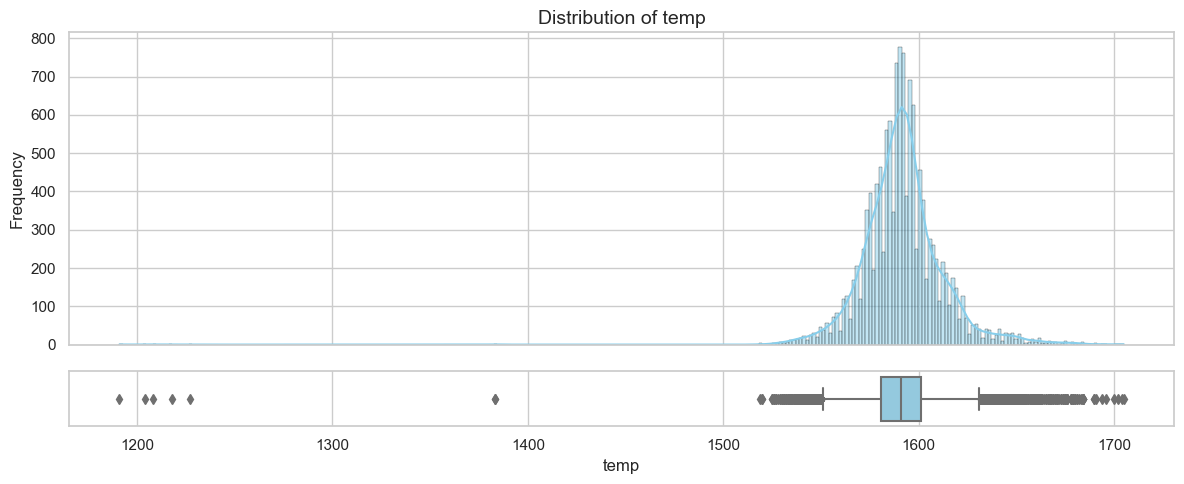

In [49]:
plot(temp_df)

The steel temperature spans between 1191 and 1705 degrees, with the majority of batches reaching temperatures around 1600 degrees.

Since the objective is to predict final temperature, it's necessary to determine which batch is not sufficient to be feature. Some batches may have intermediate temperature (not the final temperature). Also there are some data that has too low temperature. Those data need to be eliminated to fit regression assumption. 

In [50]:
# Eliminate low temperature
low_temps = temp_df[temp_df['temp'] < 1500]['key'].unique()
temp_df = temp_df[~temp_df['key'].isin(low_temps)]

In [51]:
# Check data with no final temperature
temp_df.groupby('key')['temp'].agg(
    lambda x: x.values[-1]
).isna().sum()

738

For those data, final temperature is not ommited. Delete the data with those gaps.

In [52]:
# Determine the key of the batches
nan_keys = temp_df[temp_df['temp'].isna()]['key'].unique()

# Remove the batches
temp_df = temp_df[~temp_df['key'].isin(nan_keys)]

# Show the shape of the dataframe
temp_df.shape

(12223, 3)

Check the batches that have no sufficient measurement. Which is only measured one time. If the temperature only measured 1 time, there is no initial and final temperature.

In [53]:
temp_df.groupby('key').count().query('time_sampling == 1')

,time_sampling,temp
key,,
195,1,1
279,1,1


Check those batches in `bulk`, `wire`, and `gas` dataframe.

In [54]:
# Show key 195, 279 in bulk dataframe
bulk_df.query('key == [195,279]')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
261,279,NaN,NaN,NaN,NaN,NaN,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# Show key 195, 279 in wire dataframe
wire_df.query('key == [195,279]')

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
256,279,99.066236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Show key 195, 279 in gas dataframe
gas_df.query('key == [195,279]')

,key,gas
193,195,0.374436
276,279,7.232359


Batch 195 and 279 temperature only measured 1 time and no additional materials added. So we can't use the data for feature because of lack information.

In [57]:
temp_df = temp_df.query('key!=[195, 279]')

##### Wire Alloy <a id='wire2'></a>

In [58]:
# Describe dataframe
wire_df.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


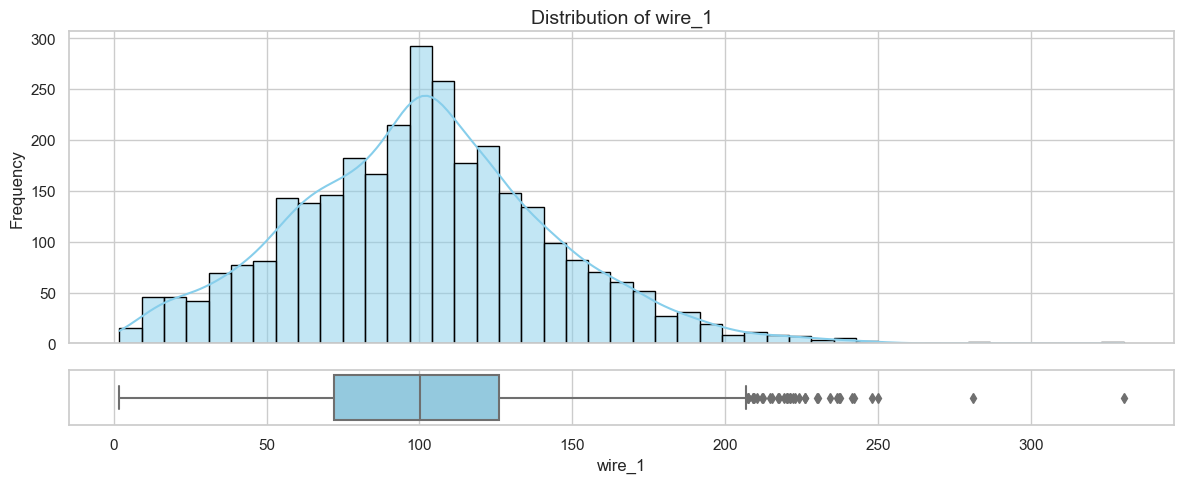

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


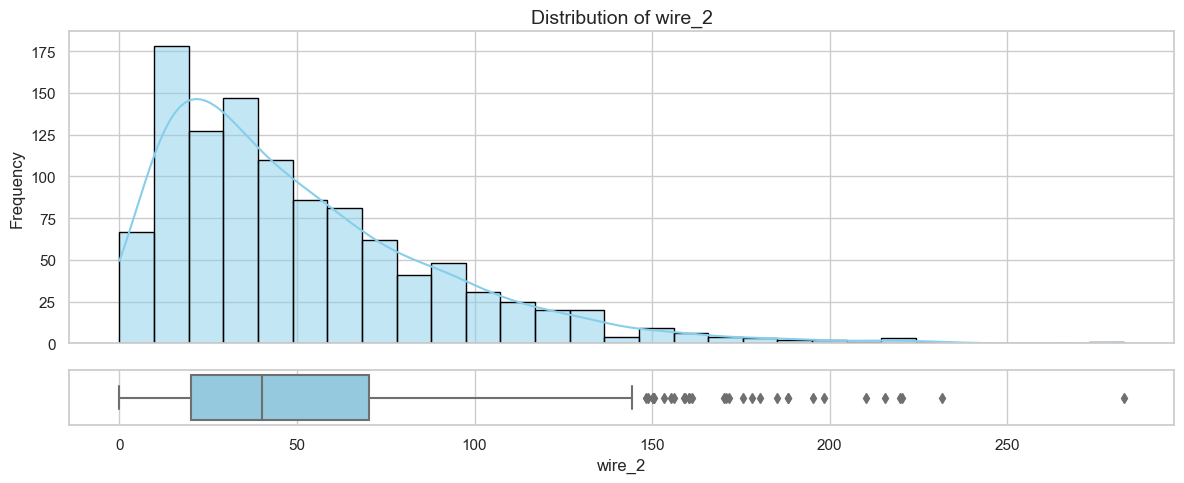

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


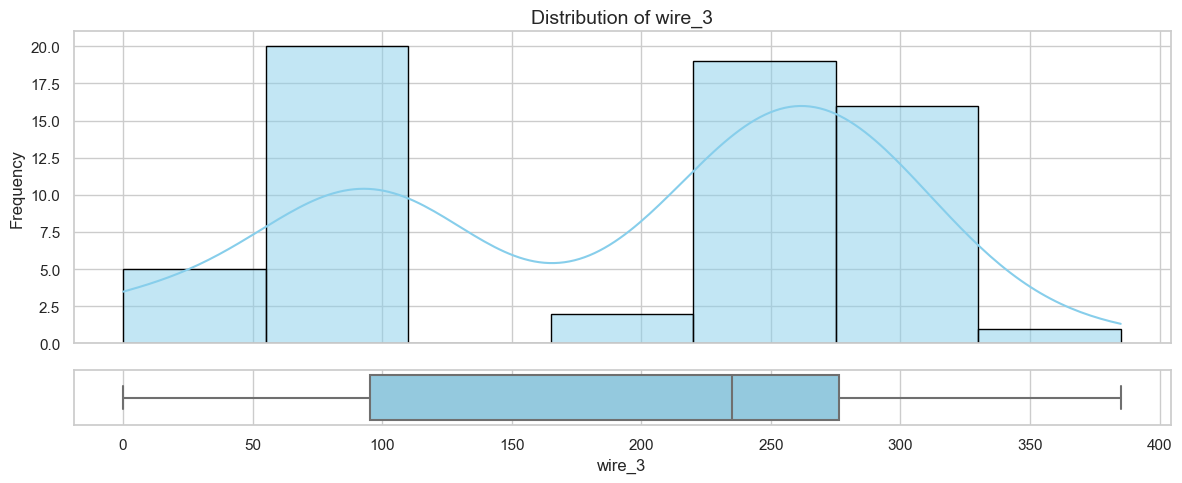

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


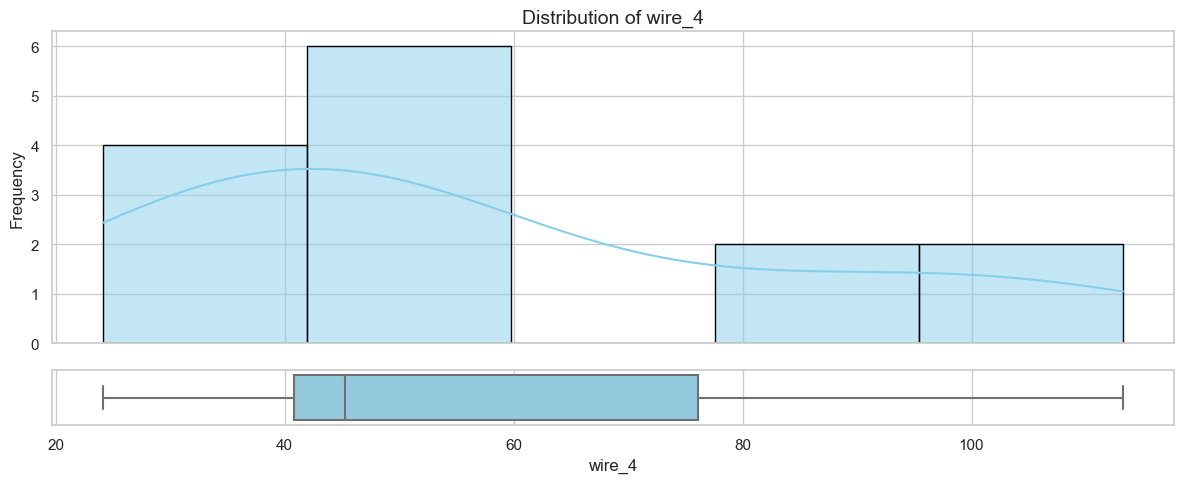

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


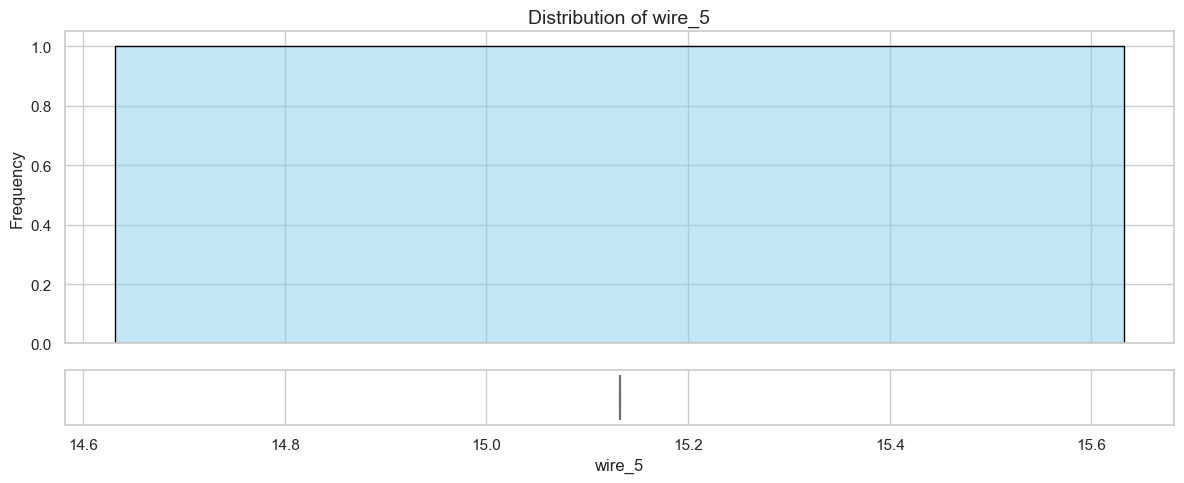

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


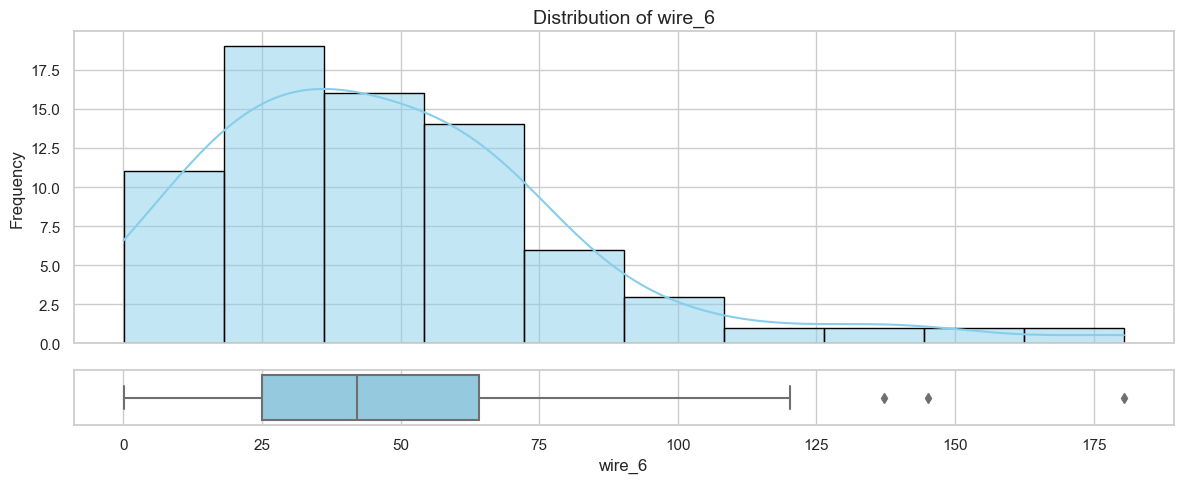

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


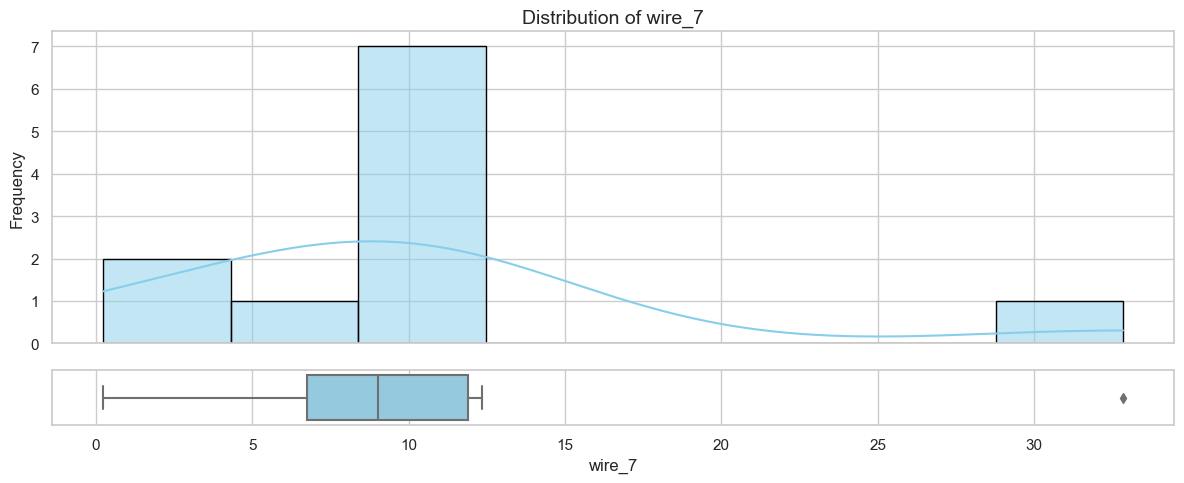

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


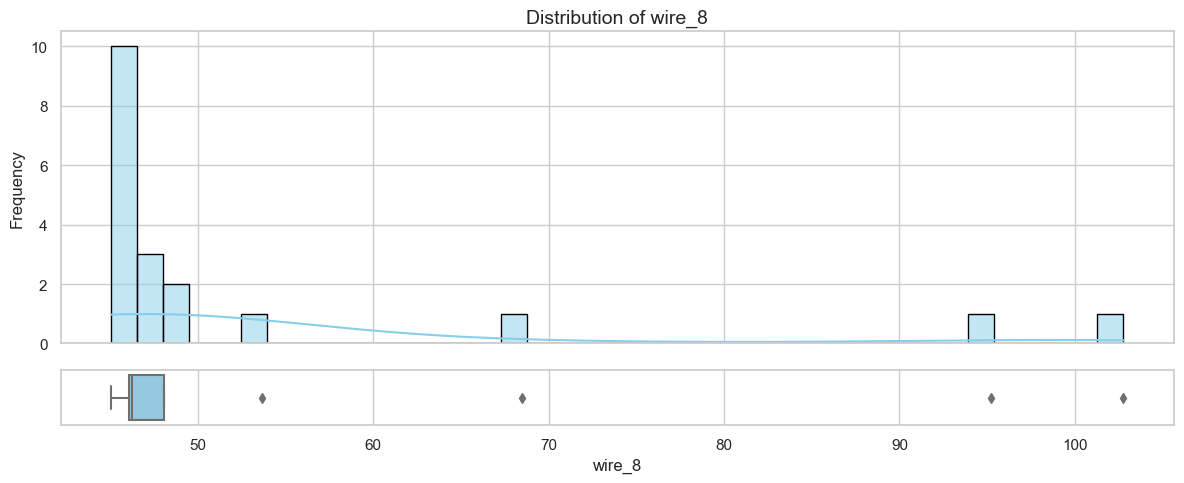

c:\Users\nashi\anaconda3\envs\PRC\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


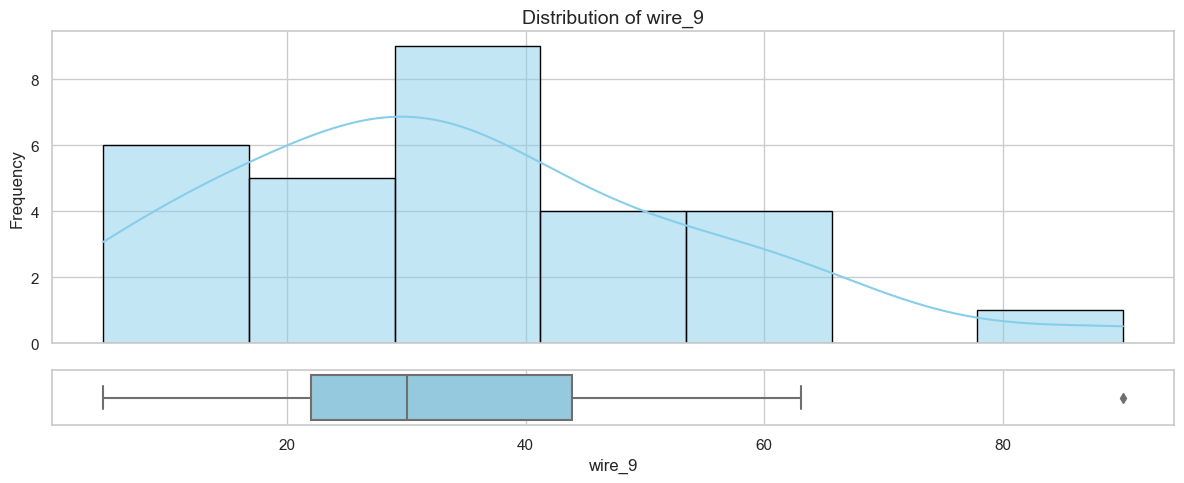

In [59]:
plot(wire_df)

- `wire_1` spans from 1.91 to 330.31, 75% of the values ​​falls up to 126, added 3055 times.
- `wire_2` spans from 0.3 to 282.78, 75% of the values ​​falls up to 77.28, added 1079 times.
- `wire_3` spans from 0.14 to 385, 75% of the values ​​falls up to 276, added 63 times.
- `wire_4` spans from 24.14 to 113.23, 75% of the values ​​falls up to 76.12, added 14 times.
- `wire_5` only added 1 time with value 15.132.
- `wire_6` spans from 0.03 to 180.45, 75% of the values ​​falls up to 64.21, added 73 times.
- `wire_7` spans from 0.23 to 32.84, 75% of the values ​​falls up to 11.89, added 11 times.
- `wire_8` spans from 45.07 to 102.86, 75% of the values ​​falls up to 48.09, added 19 times.
- `wire_9` spans from 4.62 to 90.05, 75% of the values ​​falls up to 43.86, added 29 times.

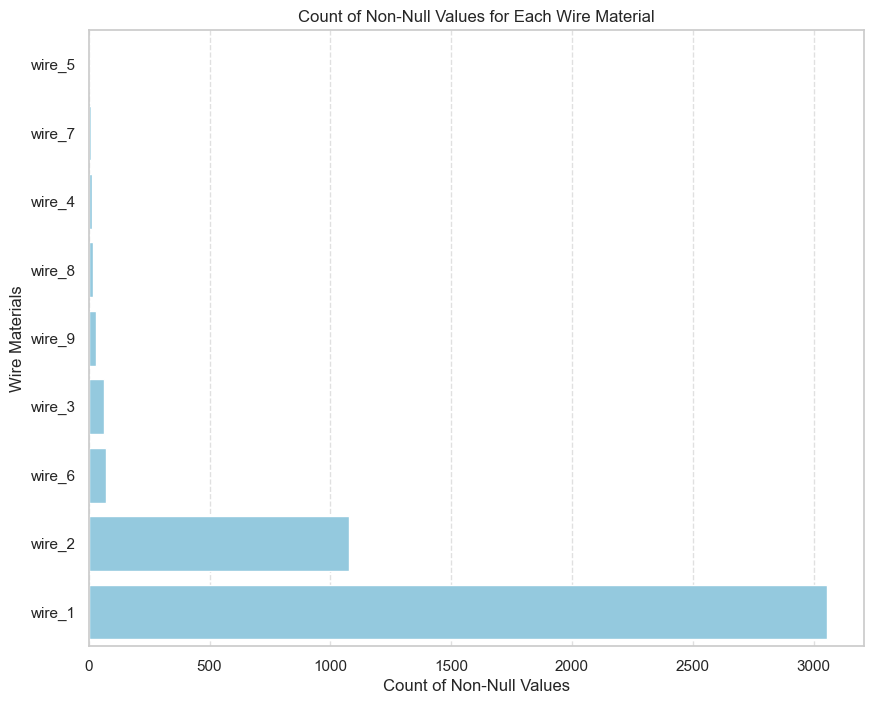

In [60]:
# Count non-null values for each column
non_null_counts2 = wire_df.loc[:, 'wire_1':].notna().sum().sort_values()

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=non_null_counts2, y=non_null_counts2.index, color='skyblue')
plt.title('Count of Non-Null Values for Each Wire Material')
plt.xlabel('Count of Non-Null Values')
plt.ylabel('Wire Materials')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the plot
plt.show()

Most of the `wire` were alloyed rarely and spans in a wide range of values, which is related to the production process.

##### Summary <a id='summary_eda'></a>

The substantial scatter of values observed in the dataset is primarily attributed to the complexity of the technological process, specifically the inherent differences in feedstock. These variations are considered normal and expected, reflecting the diverse inputs involved in the manufacturing process.

However, it's crucial to note that exceptions exist, particularly in parameters like steel temperature and reactive power of the electrodes. Recognizing their critical significance, these variables undergo a cleaning process to address anomalies, ensuring the reliability and accuracy of the data analysis in these specific aspects of the production process. Some information needs to clarify attached in questions section.

#### Data Preprocessing <a id='data_prepro'></a>

In this step, we need to determine:

1. The duration between first and last temperature measurement
2. Total electrode heating time
3. Number of electrode heating launches
4. Avg. correlation between active and reactive power consumption
5. Merge all relevant information into single datasets.

##### Electrodes (Arc) <a id='arc3'></a>

In [61]:
# Create column for duration in minutes
arc_df['arc_time'] = (arc_df['end_arc'] - arc_df['start_arc']).dt.total_seconds()/60

After round the duration in minutes, group the dataset by batch number, utilizing the mean values for power and time. Additionally, incorporate the count of electrode heatings for each steel batch to calculate number of electrodes.

In [62]:
# Group the datasets
arc_final = arc_df.groupby('key')[['active_power', 'reactive_power', 'arc_time']].agg({'active_power':['mean', 'count'],
                                                                                              'reactive_power':'mean', 
                                                                                              'arc_time':'mean'})
# Determine columns
arc_final.columns = ['active_power', 'number_arc', 'reactive_power', 'arc_time']

# Show data sample
arc_final.head()

,active_power,number_arc,reactive_power,arc_time
key,,,,
1,0.975629,5,0.636648,3.660000
2,0.763150,4,0.499528,3.379167
3,0.505176,5,0.319815,2.183333
4,0.802313,4,0.515074,3.087500
5,0.836793,4,0.563161,3.620833


Now `arc_final` dataframe created with 4 columns contains:

1. `active_power`: average of active power used on every batch.
2. `number_arc`: number of heatings by electrodes on every batch.
3. `reactive_power`: average of reactive power used on every batch.
4. `arc_time`: average duration of the electrode heating time.

(0.95, 6.333333333333333)

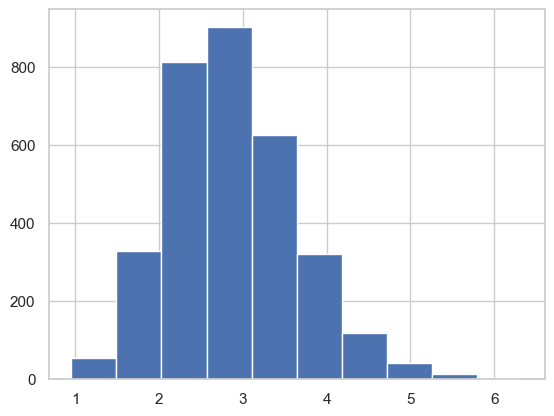

In [63]:
# Show distribution and range of the average duration
arc_final['arc_time'].hist()
arc_final['arc_time'].min(), arc_final['arc_time'].max()

(1, 16)

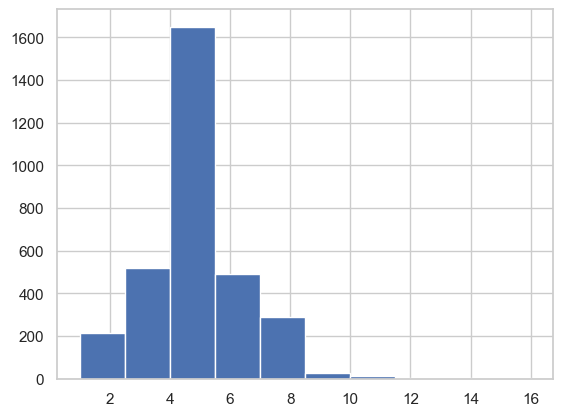

In [64]:
# Show distribution and range of the average number heatings
arc_final['number_arc'].hist()
arc_final['number_arc'].min(), arc_final['number_arc'].max()

- The average heating time spans between 0.95 to 6.33 minutes.
- The minimum number of heating by electrodes is 1 and the maximum is 16.

##### Temperature <a id='temp3'></a>

Proceeding to the temperature analysis, the initial steps involve sorting the steel temperature table by batch number and measurement time. Following this, the task is to identify the first and final temperatures of each batch, along with their respective measurement times. Finally, calculate the duration between the first and final measurements in minutes.

In [65]:
# Sorting the steel temperature table by batch number and measurement time
temp_final = temp_df.sort_values(by=['key', 'time_sampling']).groupby('key')[['temp','time_sampling']].agg(['first','last'])

# Renaming columns for clarity
temp_final.columns = ['first_temp', 'final_temp', 'first_time', 'final_time']

# Calculating the duration between first and final measurements in minutes
temp_final['delta_time'] = (temp_final['final_time'] - temp_final['first_time']).dt.total_seconds() / 60

# Dropping unnecessary columns
temp_final = temp_final.drop(['first_time', 'final_time'], axis=1)


In [66]:
# Show the data sample
temp_final.head()

,first_temp,final_temp,delta_time
key,,,
1,1571.0,1613.0,14.350000
2,1581.0,1602.0,21.750000
3,1596.0,1599.0,21.666667
4,1601.0,1625.0,6.466667
5,1576.0,1602.0,12.700000


##### Merging Table <a id='merge'></a>

Moving to the merge table section, the initial task involves filling gaps in the tables related to bulk and wire materials with zeros. This is done to signify that the material was not added during the melting of a batch of steel if there is a gap. Subsequently, the tables are merged. During this process, not all batch numbers may match across tables, leading to some tables lacking information for certain batches. To address this, lines with gaps are removed.

In [67]:
# Fill the gaps
bulk_df = bulk_df.fillna(0)
wire_df = wire_df.fillna(0)

In [68]:
# Merge datasets
df_final = temp_final.join(arc_final, how='left')
df_final = df_final.join(gas_df.set_index('key'), how='left')
df_final = df_final.join(bulk_df.set_index('key'), how='left')
df_final = df_final.join(wire_df.set_index('key'), how='left')

In [69]:
# Show data sample
df_final.head()

,first_temp,final_temp,delta_time,active_power,number_arc,reactive_power,arc_time,gas,bulk_1,bulk_2,...,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,14.350000,0.975629,5.0,0.636648,3.660000,29.749986,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1581.0,1602.0,21.750000,0.763150,4.0,0.499528,3.379167,12.555561,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1596.0,1599.0,21.666667,0.505176,5.0,0.319815,2.183333,28.554793,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1601.0,1625.0,6.466667,0.802313,4.0,0.515074,3.087500,18.841219,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1576.0,1602.0,12.700000,0.836793,4.0,0.563161,3.620833,5.413692,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# Show general information
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2470 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_temp      2470 non-null   float64
 1   final_temp      2470 non-null   float64
 2   delta_time      2470 non-null   float64
 3   active_power    2469 non-null   float64
 4   number_arc      2469 non-null   float64
 5   reactive_power  2469 non-null   float64
 6   arc_time        2469 non-null   float64
 7   gas             2468 non-null   float64
 8   bulk_1          2403 non-null   float64
 9   bulk_2          2403 non-null   float64
 10  bulk_3          2403 non-null   float64
 11  bulk_4          2403 non-null   float64
 12  bulk_5          2403 non-null   float64
 13  bulk_6          2403 non-null   float64
 14  bulk_7          2403 non-null   float64
 15  bulk_8          2403 non-null   float64
 16  bulk_9          2403 non-null   float64
 17  bulk_10         2403 non-null   float6

In [71]:
# Remove batches with insufficient information
df_final = df_final.dropna()

Since the data have merged into single dataset, multicollinearity plot can be conducted.

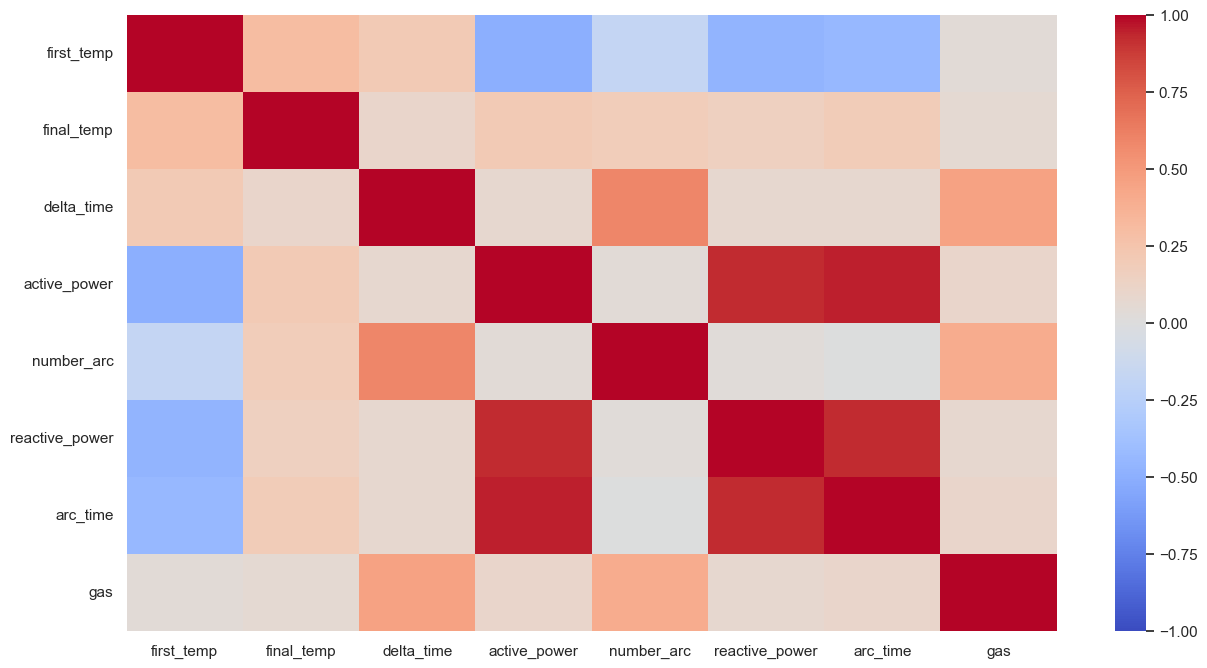

In [72]:
plt.figure(figsize=(15, 8))

# Extract the specified columns for correlation
correlation_matrix = df_final[['first_temp', 'final_temp', 'delta_time', 'active_power', 'number_arc', 
                                'reactive_power', 'arc_time', 'gas']].corr()

# Adjusted heatmap with a color scale that includes weaker correlations
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

##### Summary <a id='summary_prepro'></a>

A very strong correlation exists among the features `reactive_power`, `arc_time`, and `active_power`. Consequently, for the linear regression model, we opt to exclude Reactive Power and Arc Time due to multicollinearity, reserving them for alternative models. This decision is made to enhance the model interpretability and performance by focusing on the (hypothetically) primary predictor, which is `active_power`.

## Methodology <a id='method'></a>

The proposed methodology aims to achieve accurate temperature predictions in the steel production process:

**1. Target Determination and Data Splitting:**

Identify the target column for temperature prediction.
Split the data into training and testing sets to assess model performance.

**2. Outlier Handling: (If Needed)**

Address outliers, if necessary, focusing solely on the training data to avoid data leakage.

**3. Model Selection:**

Since the model objective is to predict final temperature, then the regression model should be fitted. In other words the model is supervised machine learning model. Choose appropriate models for the task, excluding deep learning due to the limited dataset size (only 2000s data points).

There are some potential models such as:

- Linear Regression Model
- Ridge Model
- CatBoost Regression Model
- XGB Regressor Model
- LightGBM Regressor Model
- Support Vector Regression (SVR) Model

**4. Feature Selection:**

Begin with an initial trial, utilizing four key features: `first_temp`, `number_arc`, `active_power`, and `reactive_power`.

**5. Data Scaling:**

Apply data scaling to enhance model performance and ensure consistent feature magnitudes.

**6. Model Building and Hyperparameter Tuning:**

Construct models and fine-tune hyperparameters using optuna for optimal performance.

**7. Feature Augmentation and Iterative Model Improvement:**

If the initial evaluation metric target is not achieved, iteratively introduce additional features to the model.
This iterative process aims to reduce computational load by incorporating only significant features.

**8. Model Comparison and Analysis:**

Compare the performance of each model then analyze the selected models to identify the best-fitted model for accurate temperature predictions.

This methodology aims to systematically iterate through model development and enhancement steps, optimizing the predictive capabilities of the chosen model for temperature forecasting in steel production.

## Train-Test Split <a id='split'></a>

In [73]:
# Features and target
X = df_final.drop(['final_temp'], axis=1)
y = df_final['final_temp']

In [74]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11122)

In [75]:
# Check the shape of each data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1743, 31), (581, 31), (1743,), (581,))

In [76]:
# Create compiled dictionary
compile = {
    'model': [],
    'params': [],
    'MAE': []
}

# Create function to add results to dictionary
def add_to_dict(compile, model, params, mae):
    compile['model'].append(model)
    compile['params'].append(params)
    compile['MAE'].append(mae)

The data is ready for modeling, with features and the target has been identified. The dataset also has been splited into training and testing data.

## Modeling <a id='modeling'></a>

### Linear Regression <a id='lr'></a>

Due to multicolinearity detected before, `reactive_power` and `arc_time` will be eliminated from features to focused modeling to primary feature which is `active_power`. Also follow the methodology that use selection features for initial trial and add more feature if needed.

In [78]:
# Drop feature that has multicolinearity
X_lr = X_train.drop(['reactive_power', 'arc_time'], axis=1)

In [79]:
# Define the objective function for optimization
def lr_objective(trial):
    params = {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'copy_X': trial.suggest_categorical('copy_X', [True, False])
    }

    model = LinearRegression(**params)

    # Include the standard scaler in the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # Perform cross-validation and return the mean absolute error
    mae = -cross_val_score(pipeline, X_lr, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return mae

In [80]:
# Optimize the objective function using optuna
study_lr = optuna.create_study(direction='minimize')
study_lr.optimize(lr_objective, n_trials=10)

[I 2024-01-29 22:55:35,840] A new study created in memory with name: no-name-f99a4b49-f77c-47c6-8983-3a5da2510f62
[I 2024-01-29 22:55:35,893] Trial 0 finished with value: 1593.674906666871 and parameters: {'fit_intercept': False, 'copy_X': True}. Best is trial 0 with value: 1593.674906666871.
[I 2024-01-29 22:55:35,933] Trial 1 finished with value: 1593.674906666871 and parameters: {'fit_intercept': False, 'copy_X': False}. Best is trial 0 with value: 1593.674906666871.
[I 2024-01-29 22:55:35,981] Trial 2 finished with value: 5.964352175956085 and parameters: {'fit_intercept': True, 'copy_X': False}. Best is trial 2 with value: 5.964352175956085.
[I 2024-01-29 22:55:36,020] Trial 3 finished with value: 5.964352175956085 and parameters: {'fit_intercept': True, 'copy_X': False}. Best is trial 2 with value: 5.964352175956085.
[I 2024-01-29 22:55:36,061] Trial 4 finished with value: 1593.674906666871 and parameters: {'fit_intercept': False, 'copy_X': False}. Best is trial 2 with value: 5.9

In [81]:
# Get the best hyperparameters
best_params_lr = study_lr.best_params
best_value_lr = study_lr.best_value
print("Best Hyperparameters for Linear Regression:", best_params_lr, "with value:", best_value_lr)

Best Hyperparameters for Linear Regression: {'fit_intercept': True, 'copy_X': False} with value: 5.964352175956085


In [83]:
# Create the final Linear Regression model with the best hyperparameters
lr_model = LinearRegression(**best_params_lr)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', lr_model)
])

# Fit the model on the entire training data
lr_pipeline.fit(X_lr, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LinearRegression(copy_X=False))])

In [84]:
# Add Linear Regression results to compile
add_to_dict(compile, 'Linear Regression', best_params_lr, best_value_lr)

### Ridge <a id='ridge'></a>

In [85]:
# Define the objective function for optimization
def ridge_objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 1e-3, 2, log=True),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'random_state': trial.suggest_categorical('random_state', [12345,None])
    }

    model = Ridge(**params)

    # Include the standard scaler in the pipeline
    ridge_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model)
    ])

    # Perform cross-validation and return the mean absolute error
    mae = -cross_val_score(ridge_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return mae

In [86]:
# Optimize the objective function using optuna
study_r = optuna.create_study(direction='minimize')
study_r.optimize(ridge_objective, n_trials=20)

[I 2024-01-29 22:55:52,502] A new study created in memory with name: no-name-949d8b6c-c7bd-40ef-9f31-5b2f41d54d82
[I 2024-01-29 22:55:52,541] Trial 0 finished with value: 1593.6683633716018 and parameters: {'alpha': 0.06654318223305014, 'fit_intercept': False, 'random_state': 12345}. Best is trial 0 with value: 1593.6683633716018.
[I 2024-01-29 22:55:52,575] Trial 1 finished with value: 1593.6683753825905 and parameters: {'alpha': 0.011357263552706304, 'fit_intercept': False, 'random_state': 12345}. Best is trial 0 with value: 1593.6683633716018.
[I 2024-01-29 22:55:52,619] Trial 2 finished with value: 1593.6683743894873 and parameters: {'alpha': 0.015920908108082478, 'fit_intercept': False, 'random_state': None}. Best is trial 0 with value: 1593.6683633716018.
[I 2024-01-29 22:55:52,655] Trial 3 finished with value: 1593.6683500614647 and parameters: {'alpha': 0.1276763051378177, 'fit_intercept': False, 'random_state': 12345}. Best is trial 3 with value: 1593.6683500614647.
[I 2024-01

In [87]:
# Get the best hyperparameters
best_params_rd = study_r.best_params
best_value_rd = study_r.best_value
print("Best Hyperparameters for Ridge Regressor:", best_params_rd, "with value:", best_value_rd)

Best Hyperparameters for Ridge Regressor: {'alpha': 0.0011438747814325311, 'fit_intercept': True, 'random_state': None} with value: 5.9252594434332


In [89]:
# Create the final Linear Regression model with the best hyperparameters
rd_model = Ridge(**best_params_rd)
rd_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', rd_model)
])

# Fit the model on the entire training data
rd_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', Ridge(alpha=0.0011438747814325311))])

In [90]:
# Add Linear Regression results to compile
add_to_dict(compile, 'Ridge', best_params_rd, best_value_rd)

### Catboost <a id='catboost'></a>

In [77]:
# Define the objective function for optimization
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 900, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.04),
        'depth': trial.suggest_int('depth', 4, 6),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 50, 70),
        'random_seed': trial.suggest_categorical('random_seed', [12345, None]),
        'silent': True,
    }

    model = CatBoostRegressor(**params)

    # Perform cross-validation and return the mean absolute error
    mae = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return mae

In [78]:
# Optimize the objective function using optuna
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(catboost_objective, n_trials = 50, n_jobs=-1, timeout=1500)

[I 2024-02-08 15:43:24,362] A new study created in memory with name: no-name-b756c273-b879-4817-a710-73ffde26c621
[I 2024-02-08 15:43:34,542] Trial 3 finished with value: 5.536915052793505 and parameters: {'iterations': 994, 'learning_rate': 0.03610899172164935, 'depth': 4, 'l2_leaf_reg': 3, 'border_count': 57, 'random_seed': 12345}. Best is trial 3 with value: 5.536915052793505.
[I 2024-02-08 15:43:38,456] Trial 4 finished with value: 5.543450408295084 and parameters: {'iterations': 998, 'learning_rate': 0.03494322299191052, 'depth': 5, 'l2_leaf_reg': 8, 'border_count': 54, 'random_seed': 12345}. Best is trial 3 with value: 5.536915052793505.
[I 2024-02-08 15:43:42,616] Trial 2 finished with value: 5.56928318016025 and parameters: {'iterations': 967, 'learning_rate': 0.033088841038075884, 'depth': 5, 'l2_leaf_reg': 10, 'border_count': 62, 'random_seed': 12345}. Best is trial 3 with value: 5.536915052793505.
[I 2024-02-08 15:43:42,628] Trial 0 finished with value: 5.570311918337378 and

In [79]:
# Show history of study
optuna.visualization.plot_optimization_history(study_cat)

In [96]:
# Get the best hyperparameters
best_params_c = study_cat.best_params
best_value_c = study_cat.best_value
print("Best Hyperparameters for Catboost Regressor:", best_params_c, "with value:", best_value_c)

Best Hyperparameters for Catboost Regressor: {'iterations': 955, 'learning_rate': 0.03602696633625084, 'depth': 5, 'l2_leaf_reg': 3, 'border_count': 66, 'random_seed': None} with value: 5.491545330059396


In [94]:
# Create the final Linear Regression model with the best hyperparameters
c_model = CatBoostRegressor(**best_params_c)
c_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', c_model)
])

# Fit the model on the entire training data
c_pipeline.fit(X_train, y_train)

0:	learn: 11.1498264	total: 1.38ms	remaining: 1.32s
1:	learn: 11.0688211	total: 2.67ms	remaining: 1.27s
2:	learn: 10.9667744	total: 3.76ms	remaining: 1.19s
3:	learn: 10.8876729	total: 4.78ms	remaining: 1.14s
4:	learn: 10.8174109	total: 5.81ms	remaining: 1.1s
5:	learn: 10.7442902	total: 6.87ms	remaining: 1.09s
6:	learn: 10.6584710	total: 8.07ms	remaining: 1.09s
7:	learn: 10.5823226	total: 9.31ms	remaining: 1.1s
8:	learn: 10.5131358	total: 10.6ms	remaining: 1.11s
9:	learn: 10.4639480	total: 12.5ms	remaining: 1.18s
10:	learn: 10.3881462	total: 13.8ms	remaining: 1.19s
11:	learn: 10.3342955	total: 15.1ms	remaining: 1.19s
12:	learn: 10.2703530	total: 16.2ms	remaining: 1.18s
13:	learn: 10.2091660	total: 17.6ms	remaining: 1.18s
14:	learn: 10.1323989	total: 18.8ms	remaining: 1.18s
15:	learn: 10.0836322	total: 20ms	remaining: 1.17s
16:	learn: 10.0204892	total: 21.4ms	remaining: 1.18s
17:	learn: 9.9680070	total: 22.5ms	remaining: 1.17s
18:	learn: 9.9197784	total: 23.5ms	remaining: 1.16s
19:	learn

151:	learn: 7.3647470	total: 194ms	remaining: 1.03s
152:	learn: 7.3578911	total: 196ms	remaining: 1.03s
153:	learn: 7.3490906	total: 198ms	remaining: 1.03s
154:	learn: 7.3428299	total: 199ms	remaining: 1.03s
155:	learn: 7.3368228	total: 200ms	remaining: 1.02s
156:	learn: 7.3232763	total: 201ms	remaining: 1.02s
157:	learn: 7.3166323	total: 202ms	remaining: 1.02s
158:	learn: 7.3084623	total: 204ms	remaining: 1.02s
159:	learn: 7.3015190	total: 205ms	remaining: 1.02s
160:	learn: 7.2898322	total: 206ms	remaining: 1.02s
161:	learn: 7.2839164	total: 208ms	remaining: 1.02s
162:	learn: 7.2736545	total: 210ms	remaining: 1.02s
163:	learn: 7.2673305	total: 212ms	remaining: 1.02s
164:	learn: 7.2554813	total: 213ms	remaining: 1.02s
165:	learn: 7.2473397	total: 215ms	remaining: 1.02s
166:	learn: 7.2386646	total: 216ms	remaining: 1.02s
167:	learn: 7.2264095	total: 218ms	remaining: 1.02s
168:	learn: 7.2182038	total: 219ms	remaining: 1.02s
169:	learn: 7.2122319	total: 220ms	remaining: 1.02s
170:	learn: 

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 <catboost.core.CatBoostRegressor object at 0x000001B88934D510>)])

In [95]:
# Add Linear Regression results to compile
add_to_dict(compile, 'Catboost', best_params_c, best_value_c)

### XGBoost <a id='xgbost'></a>

In [97]:
# Define the objective function for optimization
def xgboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 100),
        'random_state': trial.suggest_categorical('random_state',[12345,None])
    }

    model = XGBRegressor(
        booster="gbtree",
        objective='reg:squarederror',
        **params
        )

    # Perform cross-validation and return the mean absolute error
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return score

In [98]:
# Create an Optuna study
xgboost_study = optuna.create_study(direction='maximize')
xgboost_study.optimize(xgboost_objective, n_trials=50, n_jobs=-1, timeout=700)

[I 2024-01-29 22:59:08,441] A new study created in memory with name: no-name-a811237c-2082-4d10-b526-21d96196ef67
[I 2024-01-29 22:59:13,234] Trial 3 finished with value: -5.984531322808793 and parameters: {'n_estimators': 317, 'learning_rate': 0.0443339536209225, 'max_depth': 3, 'subsample': 0.6623321435064349, 'colsample_bytree': 0.7232623602944857, 'reg_alpha': 68.06812599414754, 'reg_lambda': 34.61424889560107, 'random_state': 12345}. Best is trial 3 with value: -5.984531322808793.
[I 2024-01-29 22:59:17,500] Trial 5 finished with value: -5.959676707815253 and parameters: {'n_estimators': 345, 'learning_rate': 0.042645292877269, 'max_depth': 5, 'subsample': 0.6180097793622037, 'colsample_bytree': 0.7207820362537094, 'reg_alpha': 15.229233569620485, 'reg_lambda': 90.65418529696817, 'random_state': 12345}. Best is trial 5 with value: -5.959676707815253.
[I 2024-01-29 22:59:21,594] Trial 0 finished with value: -6.611948865585144 and parameters: {'n_estimators': 513, 'learning_rate': 0

In [99]:
# Get the best hyperparameters
best_params_xgboost = xgboost_study.best_params
best_value_xgboost = xgboost_study.best_value
print("Best Hyperparameters for XGBoost Regressor:", best_params_xgboost, "with value:", best_value_xgboost)

Best Hyperparameters for XGBoost Regressor: {'n_estimators': 230, 'learning_rate': 0.12731494789545936, 'max_depth': 4, 'subsample': 0.7277835512994353, 'colsample_bytree': 0.7965089641650747, 'reg_alpha': 55.341706580897785, 'reg_lambda': 73.65779791394809, 'random_state': 12345} with value: -5.683767017034958


In [100]:
# Create the final Linear Regression model with the best hyperparameters
xgboost_model = XGBRegressor(
    booster="gbtree",
    objective='reg:squarederror',
    **best_params_xgboost,
    )
xgboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgboost_model)
])

# Fit the model on the entire training data
xgboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.7965089641650747,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.12731494789545936, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=230,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=12345, ...))])

In [101]:
# Add Linear Regression results to compile
add_to_dict(compile, 'XGBoost', best_params_xgboost, abs(best_value_xgboost))

### LightGBM <a id='lightgbm'></a>

In [102]:
# Define the objective function for optimization
def lightgbm_objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 10, 14),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.3),
        'random_state': trial.suggest_categorical('random_state',[12345,None]),
    }

    model = LGBMRegressor(
        force_col_wise = True,
        **params,
        silent=True,
        )

    # Perform cross-validation and return the mean absolute error
    mae = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

    return mae

In [103]:
# Create an Optuna study
lgb_study = optuna.create_study(direction='minimize')
lgb_study.optimize(lightgbm_objective, n_trials=50)

[I 2024-01-29 23:01:12,987] A new study created in memory with name: no-name-aef656c5-5a80-4fee-a97d-a1d734161827


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 21
[LightGBM] [Info] Start training from score 1593.516499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-01-29 23:01:13,672] Trial 0 finished with value: 6.43822261575747 and parameters: {'num_leaves': 175, 'learning_rate': 0.013960632919848403, 'max_depth': 10, 'reg_alpha': 0.29402431609664087, 'random_state': None}. Best is trial 0 with value: 6.43822261575747.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:14,241] Trial 1 finished with value: 6.038715697794558 and parameters: {'num_leaves': 101, 'learning_rate': 0.022688985473941846, 'max_depth': 13, 'reg_alpha': 0.03339304560504609, 'random_state': 12345}. Best is trial 1 with value: 6.038715697794558.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:14,738] Trial 2 finished with value: 5.754497634880754 and parameters: {'num_leaves': 166, 'learning_rate': 0.08300007521373037, 'max_depth': 13, 'reg_alpha': 0.032549777236341816, 'random_state': None}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:15,172] Trial 3 finished with value: 5.7710311612730205 and parameters: {'num_leaves': 133, 'learning_rate': 0.049496843924975185, 'max_depth': 10, 'reg_alpha': 0.15928901961258354, 'random_state': None}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:15,791] Trial 4 finished with value: 6.169785157139567 and parameters: {'num_leaves': 157, 'learning_rate': 0.019107376243487045, 'max_depth': 11, 'reg_alpha': 0.2143996289964835, 'random_state': 12345}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:16,234] Trial 5 finished with value: 5.811680776038028 and parameters: {'num_leaves': 135, 'learning_rate': 0.09493512762981894, 'max_depth': 10, 'reg_alpha': 0.21812080594825303, 'random_state': 12345}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[Light

[I 2024-01-29 23:01:16,763] Trial 6 finished with value: 5.818289818127316 and parameters: {'num_leaves': 122, 'learning_rate': 0.09588764610368919, 'max_depth': 14, 'reg_alpha': 0.2675911161187813, 'random_state': None}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:17,371] Trial 7 finished with value: 5.760535262921955 and parameters: {'num_leaves': 180, 'learning_rate': 0.06931532554589565, 'max_depth': 14, 'reg_alpha': 0.08103630865134348, 'random_state': None}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:17,867] Trial 8 finished with value: 5.821766767603826 and parameters: {'num_leaves': 130, 'learning_rate': 0.04094343603630733, 'max_depth': 10, 'reg_alpha': 0.1338583724789392, 'random_state': 12345}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:18,363] Trial 9 finished with value: 5.79326455045562 and parameters: {'num_leaves': 140, 'learning_rate': 0.04369895149944054, 'max_depth': 11, 'reg_alpha': 0.012168700889518854, 'random_state': None}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:18,885] Trial 10 finished with value: 5.786746912879626 and parameters: {'num_leaves': 197, 'learning_rate': 0.07607316424398304, 'max_depth': 13, 'reg_alpha': 0.08125762012142837, 'random_state': None}. Best is trial 2 with value: 5.754497634880754.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:19,446] Trial 11 finished with value: 5.7397849964382335 and parameters: {'num_leaves': 172, 'learning_rate': 0.07458537072467894, 'max_depth': 14, 'reg_alpha': 0.07773239053795183, 'random_state': None}. Best is trial 11 with value: 5.7397849964382335.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:19,968] Trial 12 finished with value: 5.732384568809127 and parameters: {'num_leaves': 163, 'learning_rate': 0.07074632181952312, 'max_depth': 13, 'reg_alpha': 0.0724454032993145, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:20,538] Trial 13 finished with value: 5.798023376252544 and parameters: {'num_leaves': 189, 'learning_rate': 0.06735690448576638, 'max_depth': 14, 'reg_alpha': 0.09698508992246926, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 21
[LightGBM] [Info] Start training from score 1593.516499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-01-29 23:01:21,118] Trial 14 finished with value: 5.778861410935269 and parameters: {'num_leaves': 161, 'learning_rate': 0.060204900362509334, 'max_depth': 12, 'reg_alpha': 0.11950134510889496, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:21,630] Trial 15 finished with value: 5.7752463081852765 and parameters: {'num_leaves': 146, 'learning_rate': 0.08286941112320742, 'max_depth': 13, 'reg_alpha': 0.05404511199078292, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:22,175] Trial 16 finished with value: 5.763869731408214 and parameters: {'num_leaves': 171, 'learning_rate': 0.05868693623491714, 'max_depth': 12, 'reg_alpha': 0.17787835201256552, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 21
[LightGBM] [Info] Start training from score 1593.621505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-01-29 23:01:22,679] Trial 17 finished with value: 5.783193107468964 and parameters: {'num_leaves': 153, 'learning_rate': 0.08380078899002558, 'max_depth': 14, 'reg_alpha': 0.06126854234960319, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:23,289] Trial 18 finished with value: 5.847238499212708 and parameters: {'num_leaves': 185, 'learning_rate': 0.03514288011801236, 'max_depth': 13, 'reg_alpha': 0.11510834838710032, 'random_state': 12345}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:23,852] Trial 19 finished with value: 5.75979123619212 and parameters: {'num_leaves': 196, 'learning_rate': 0.05400474890475125, 'max_depth': 12, 'reg_alpha': 0.1561259993437848, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:24,511] Trial 20 finished with value: 5.789122657669118 and parameters: {'num_leaves': 116, 'learning_rate': 0.06879341664238604, 'max_depth': 14, 'reg_alpha': 0.18946428224483988, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:25,075] Trial 21 finished with value: 5.765919265558396 and parameters: {'num_leaves': 167, 'learning_rate': 0.0850657975837415, 'max_depth': 13, 'reg_alpha': 0.010433400344801981, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:25,629] Trial 22 finished with value: 5.7749104464417975 and parameters: {'num_leaves': 170, 'learning_rate': 0.07523249811672848, 'max_depth': 13, 'reg_alpha': 0.04827154635906447, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:26,126] Trial 23 finished with value: 5.761319145750181 and parameters: {'num_leaves': 162, 'learning_rate': 0.09984308382436802, 'max_depth': 13, 'reg_alpha': 0.0833001956123457, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:26,638] Trial 24 finished with value: 5.810910991776287 and parameters: {'num_leaves': 151, 'learning_rate': 0.08848500564128184, 'max_depth': 14, 'reg_alpha': 0.030067489555833764, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:27,136] Trial 25 finished with value: 5.784032423155922 and parameters: {'num_leaves': 178, 'learning_rate': 0.07654235458517065, 'max_depth': 12, 'reg_alpha': 0.06493265921452838, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 21
[LightGBM] [Info] Start training from score 1593.516499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-01-29 23:01:27,722] Trial 26 finished with value: 5.762194008324587 and parameters: {'num_leaves': 165, 'learning_rate': 0.06179814245336965, 'max_depth': 13, 'reg_alpha': 0.037985008340880845, 'random_state': 12345}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:28,356] Trial 27 finished with value: 7.50853612292777 and parameters: {'num_leaves': 145, 'learning_rate': 0.0027613433915749455, 'max_depth': 14, 'reg_alpha': 0.10526072205890674, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:28,829] Trial 28 finished with value: 5.780868835402689 and parameters: {'num_leaves': 187, 'learning_rate': 0.0914113024679945, 'max_depth': 11, 'reg_alpha': 0.0732171324954434, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:29,373] Trial 29 finished with value: 5.769751144847561 and parameters: {'num_leaves': 175, 'learning_rate': 0.0787226840360389, 'max_depth': 13, 'reg_alpha': 0.1355947669058898, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:29,960] Trial 30 finished with value: 5.768843928058837 and parameters: {'num_leaves': 156, 'learning_rate': 0.06904367742539681, 'max_depth': 14, 'reg_alpha': 0.09429326296746138, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:30,515] Trial 31 finished with value: 5.754481515662048 and parameters: {'num_leaves': 199, 'learning_rate': 0.06218515565935218, 'max_depth': 12, 'reg_alpha': 0.1542586625867268, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:31,054] Trial 32 finished with value: 5.781534867855159 and parameters: {'num_leaves': 193, 'learning_rate': 0.06415072267729433, 'max_depth': 12, 'reg_alpha': 0.29501500304687356, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:31,655] Trial 33 finished with value: 5.813262361694981 and parameters: {'num_leaves': 183, 'learning_rate': 0.05337687809237703, 'max_depth': 12, 'reg_alpha': 0.029817597154115107, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:32,176] Trial 34 finished with value: 5.756361243687183 and parameters: {'num_leaves': 174, 'learning_rate': 0.07261125104901396, 'max_depth': 12, 'reg_alpha': 0.262288530995756, 'random_state': 12345}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:32,683] Trial 35 finished with value: 5.7811451011827515 and parameters: {'num_leaves': 200, 'learning_rate': 0.08005894786940679, 'max_depth': 11, 'reg_alpha': 0.1369260510890269, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:33,356] Trial 36 finished with value: 5.941747806781356 and parameters: {'num_leaves': 158, 'learning_rate': 0.027365463205993742, 'max_depth': 13, 'reg_alpha': 0.2052230085918322, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:33,925] Trial 37 finished with value: 5.7950632470443475 and parameters: {'num_leaves': 167, 'learning_rate': 0.047732921992664296, 'max_depth': 12, 'reg_alpha': 0.2440970684826047, 'random_state': 12345}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:34,446] Trial 38 finished with value: 5.747537896284034 and parameters: {'num_leaves': 179, 'learning_rate': 0.09166891043646906, 'max_depth': 13, 'reg_alpha': 0.04056033327335406, 'random_state': None}. Best is trial 12 with value: 5.732384568809127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:35,031] Trial 39 finished with value: 5.721531905442842 and parameters: {'num_leaves': 191, 'learning_rate': 0.08918077673795818, 'max_depth': 13, 'reg_alpha': 0.16877289543265522, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 1394, number of u

[I 2024-01-29 23:01:35,561] Trial 40 finished with value: 5.799764474268377 and parameters: {'num_leaves': 190, 'learning_rate': 0.09083327309218858, 'max_depth': 13, 'reg_alpha': 0.17368650698159308, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2578


[I 2024-01-29 23:01:36,098] Trial 41 finished with value: 5.796546075158725 and parameters: {'num_leaves': 181, 'learning_rate': 0.09880347945579981, 'max_depth': 13, 'reg_alpha': 0.22855559344931156, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:36,707] Trial 42 finished with value: 5.768544627896274 and parameters: {'num_leaves': 193, 'learning_rate': 0.08780313016807202, 'max_depth': 14, 'reg_alpha': 0.172224035480676, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 21
[LightGBM] [Info] Start training from score 1593.516499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-01-29 23:01:37,223] Trial 43 finished with value: 5.7606979237034315 and parameters: {'num_leaves': 200, 'learning_rate': 0.09285851551900204, 'max_depth': 11, 'reg_alpha': 0.14867337527756486, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 21
[LightGBM] [Info] Start training from score 1593.539068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-01-29 23:01:37,768] Trial 44 finished with value: 5.777137150594708 and parameters: {'num_leaves': 180, 'learning_rate': 0.07253831580950469, 'max_depth': 13, 'reg_alpha': 0.19671386344770603, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:38,364] Trial 45 finished with value: 5.7559225322572365 and parameters: {'num_leaves': 104, 'learning_rate': 0.05678541231744481, 'max_depth': 12, 'reg_alpha': 0.12274570029196409, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2572
[LightGBM] [Info] Number of data points in the train set: 1394, number of used features: 21
[LightGBM] [Info] Start training from score 1593.516499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-01-29 23:01:38,933] Trial 46 finished with value: 5.758771095378408 and parameters: {'num_leaves': 190, 'learning_rate': 0.06526603965523171, 'max_depth': 14, 'reg_alpha': 0.09439271964728113, 'random_state': 12345}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-01-29 23:01:39,447] Trial 47 finished with value: 5.76572474565067 and parameters: {'num_leaves': 178, 'learning_rate': 0.08103207239753323, 'max_depth': 12, 'reg_alpha': 0.04434128240380589, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 21
[LightGBM] [Info] Start training from score 1593.539068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[I 2024-01-29 23:01:40,122] Trial 48 finished with value: 5.747665237236622 and parameters: {'num_leaves': 174, 'learning_rate': 0.09527097315780465, 'max_depth': 13, 'reg_alpha': 0.020963233178349677, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1395, number of used features: 21
[LightGBM] [Info] Start training from score 1593.539068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-01-29 23:01:40,738] Trial 49 finished with value: 5.796294106276524 and parameters: {'num_leaves': 174, 'learning_rate': 0.09581774172514107, 'max_depth': 13, 'reg_alpha': 0.024403549583952022, 'random_state': None}. Best is trial 39 with value: 5.721531905442842.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [104]:
# Get the best hyperparameters
best_params_lgb = lgb_study.best_params
best_value_lgb = lgb_study.best_value
print("Best Hyperparameters for LightGBM Regressor:", best_params_lgb, "with value:", best_value_lgb)

Best Hyperparameters for LightGBM Regressor: {'num_leaves': 191, 'learning_rate': 0.08918077673795818, 'max_depth': 13, 'reg_alpha': 0.16877289543265522, 'random_state': None} with value: 5.721531905442842


Do the same trial repition until best model reached then train the final ridge model.

In [105]:
# Create the final Linear Regression model with the best hyperparameters
lgb_model = LGBMRegressor(
    **best_params_lgb,
    force_col_wise = True,
    verbose=-1,
    )
lgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', lgb_model)
])

# Fit the model on the entire training data
lgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LGBMRegressor(force_col_wise=True,
                               learning_rate=0.08918077673795818, max_depth=13,
                               num_leaves=191, reg_alpha=0.16877289543265522,
                               verbose=-1))])

In [106]:
# Add Linear Regression results to compile
add_to_dict(compile, 'LightGBM', best_params_lgb, best_value_lgb)

## Model Evaluation <a id='evaluation'></a>

### Compile <a id='compile'></a>

In [109]:
# Show compile
pd.DataFrame(compile).sort_values('MAE')

,model,params,MAE
2,Catboost,"{'iterations': 955, 'learning_rate': 0.0360269...",5.491545
3,XGBoost,"{'n_estimators': 230, 'learning_rate': 0.12731...",5.683767
4,LightGBM,"{'num_leaves': 191, 'learning_rate': 0.0891807...",5.721532
1,Ridge,"{'alpha': 0.0011438747814325311, 'fit_intercep...",5.925259
0,Linear Regression,"{'fit_intercept': True, 'copy_X': False}",5.964352


### Test Best Model <a id='test'></a>

In [114]:
# Predict test set using best model
c_model = c_pipeline.named_steps['clf']
c_model.fit(X_train, y_train)
predictions = c_model.predict(X_test)
mae_pred = mean_absolute_error(y_test, predictions)
mae_pred

0:	learn: 11.1498264	total: 1.56ms	remaining: 1.49s
1:	learn: 11.0688211	total: 3.51ms	remaining: 1.67s
2:	learn: 10.9667551	total: 4.63ms	remaining: 1.47s
3:	learn: 10.8876509	total: 5.99ms	remaining: 1.42s
4:	learn: 10.8174128	total: 7ms	remaining: 1.33s
5:	learn: 10.7443164	total: 7.91ms	remaining: 1.25s
6:	learn: 10.6585083	total: 9.75ms	remaining: 1.32s
7:	learn: 10.5829900	total: 11.6ms	remaining: 1.37s
8:	learn: 10.5135806	total: 13.4ms	remaining: 1.41s
9:	learn: 10.4644463	total: 15ms	remaining: 1.41s
10:	learn: 10.3828986	total: 16.3ms	remaining: 1.4s
11:	learn: 10.3292078	total: 17.6ms	remaining: 1.38s
12:	learn: 10.2649737	total: 19.3ms	remaining: 1.4s
13:	learn: 10.2028683	total: 21.9ms	remaining: 1.47s
14:	learn: 10.1326564	total: 25ms	remaining: 1.56s
15:	learn: 10.0833795	total: 26.6ms	remaining: 1.56s
16:	learn: 10.0135063	total: 27.9ms	remaining: 1.54s
17:	learn: 9.9461630	total: 29.1ms	remaining: 1.52s
18:	learn: 9.9031265	total: 30.2ms	remaining: 1.49s
19:	learn: 9.8

5.696331085693176

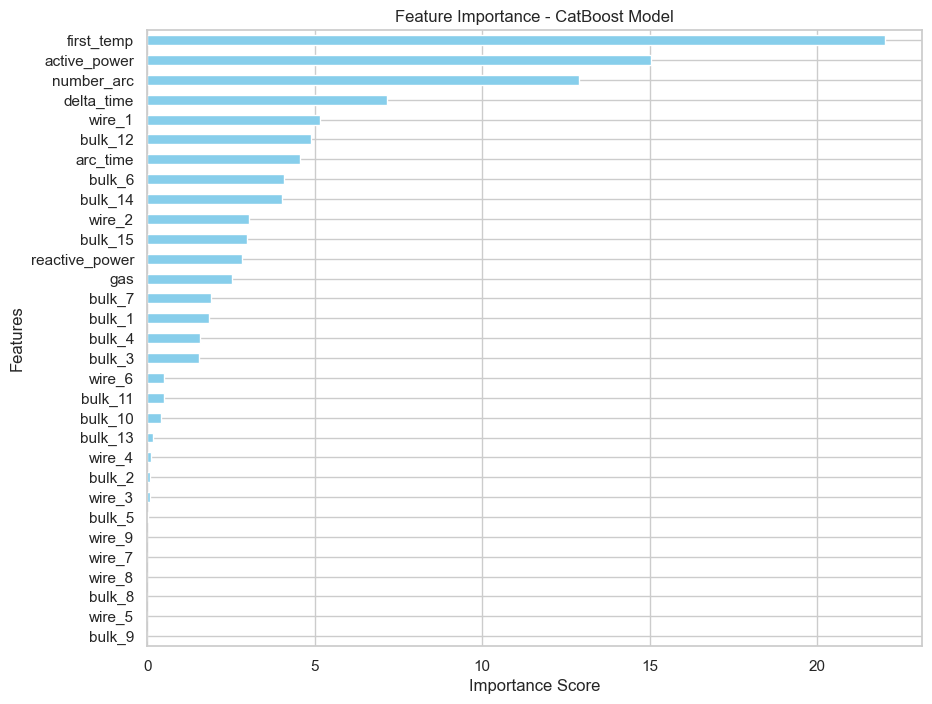

In [115]:
# Create feature importance
feature_importance = pd.Series(c_model.get_feature_importance(Pool(X_train, y_train, feature_names=list(X_train.columns))), 
                               index=X_train.columns)

# Sort values
feature_importance = feature_importance.sort_values()

# Plotting
plt.figure(figsize=(10, 8))
feature_importance.plot(kind='barh', color='skyblue')
plt.title('Feature Importance - CatBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## Discussion <a id='discuss'></a>

### Analysis <a id='Analysis'></a>

1. I do a little change in temperature data. I remove batch that has low temperature which I set to 1500 degree. This adjustment results mae on regressor model. It has linear interpretation due to regressor model can't catch extreme value.

2. Support Vector Regressor (SVR) not suitable to use because of the model take time too long to study using optuna. The study duration is linear to regularization parameter (C), as I tried and compared before with lower regularization parameter. But the results is still not meet the lowest model by compare it to previouse model trained. So I interrupt the study and abandoned it.

3. The proposed feature selection cycle (as outlined in the methodology) suggests that while there might be only a slight improvement in computation efficiency. In other words, the impact on the model's performance optimize is minimal for this datasets and model. However, for scenarios where computational resources are a crucial consideration, removing features with low importance scores can be done to optimize resource utilization.

### Model Evaluation Report <a id='report'></a>

Catboost Regressor emerged as the most effective predictive model, yielding a Mean Absolute Error (MAE) of 5.69 degrees on the validation data. It's essential to highlight the key features influencing this model's predictions, with the initial steel temperature (`first_temp`), active power (`active_power`), and the number of arc heatings (`num_arc`) standing out as the most impactful. On the other hand, certain materials like Wire 13, Wire 4, Bulk 8, and Bulk 9 demonstrated minimal influence, likely due to their infrequent use during the steel melting process as explained in data preparation section.

### Conclusion <a id='conclusion'></a>

A comprehensive analysis of the steel melting process has been conducted, encompassing datasets included electrodes, bulk materials (volume and supply time), gas purging of the alloy, wire materials (volume and time), and temperature measurements of the steel.

During the metal melting process, electrodes play a pivotal role in heating the ladle. The heating power, characterized by active and reactive power, reflects the conversion of electrical energy into useful heat and the loads created in electrical devices due to fluctuations in the electromagnetic field.

To achieve specific steel grades, loose and wire-like materials are added and stirred with gas to achieve targeted composition. The dataset includes 15 bulk materials and 9 wire materials. Notably, there are gaps in the data, as only certain substances are added for a given batch for different composition. The frequency of material additions are vary, certain materials being added more frequently than others.

For model training, a processed dataset was done. Encompassing initial and final steel temperatures, time intervals between temperature measurements, active and reactive power of electrodes, number of electrode heatings, arc heating time, gas volume, and volumes of various bulk and wire materials.

Finally, the most effective model for predicting the final temperature of a steel batch is the CatBoost Regression Model with optimized hyperparameters:

- `'iterations': 955,`
- `'learning_rate': 0.03602696633625084,`
- `'depth': 5,`
- `'l2_leaf_reg': 3,`
- `'border_count': 66,`
- `'random_seed': None`

This model demonstrated a Mean Absolute Error (MAE) of 5.4 in training data and 5.69 degrees on the test sample (indicating a reliable performance).